In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets torch tensorboard
!pip install -q pyyaml jsonschema kubernetes
!pip install -q pandas numpy scikit-learn matplotlib seaborn
!pip install -q accelerate sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 5.9 MB/s eta 0:00:00


In [3]:
# Check GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [4]:
import os
import json
import yaml
import time
import random
import requests
from pathlib import Path
from typing import Dict, List, Any, Tuple
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import Dataset, DatasetDict

# Set random seeds for reproducibility
def set_seed(seed=12):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(12)

In [5]:
# Create project directories
import os

base_dir = "/content/drive/MyDrive/ravali/thesis-research"
directories = [
    "baseline", "data/raw", "data/processed", "data/train",
    "data/val", "data/test", "models", "results", "scripts",
    "data/raw/deployments", "data/raw/services",
    "data/raw/configmaps", "data/raw/ingresses",
    "data/raw/statefulsets"
]

for directory in directories:
    os.makedirs(f"{base_dir}/{directory}", exist_ok=True)

os.chdir(base_dir)
print(f"Working directory: {os.getcwd()}")

Working directory: /content/drive/MyDrive/ravali/thesis-research


In [ ]:
"""
Enhanced Kubernetes Manifest Data Collection Script
====================================================
Collects 100+ production-grade Kubernetes manifests from real-world sources.

Sources:
- Official Kubernetes examples
- Bitnami Helm charts
- CNCF graduated projects
- Popular open-source applications
"""

import os
import json
import yaml
import requests
import time
from pathlib import Path
from typing import Dict, List, Any, Tuple
from datetime import datetime
import base64
from collections import defaultdict
from google.colab import userdata

class KubernetesManifestCollector:
    """
    Collects real Kubernetes manifests from GitHub repositories
    """

    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(parents=True, exist_ok=True)

        # Create subdirectories for different resource types
        self.resource_dirs = {
            'deployment': self.base_dir / 'deployments',
            'service': self.base_dir / 'services',
            'configmap': self.base_dir / 'configmaps',
            'ingress': self.base_dir / 'ingresses',
            'statefulset': self.base_dir / 'statefulsets',
            'daemonset': self.base_dir / 'daemonsets',
            'job': self.base_dir / 'jobs',
            'cronjob': self.base_dir / 'cronjobs',
            'pvc': self.base_dir / 'pvcs',
            'secret': self.base_dir / 'secrets',
            'hpa': self.base_dir / 'hpas',
            'networkpolicy': self.base_dir / 'networkpolicies',
            'other': self.base_dir / 'other'
        }

        for dir_path in self.resource_dirs.values():
            dir_path.mkdir(parents=True, exist_ok=True)

        self.metadata = []
        self.stats = defaultdict(int)

        # Get GitHub token from Colab secrets
        github_token = userdata.get('GITHUB_TOKEN')
        if github_token:
            self.headers = {'Authorization': f'token {github_token}'}
            print("Using GitHub token for authenticated requests.")
        else:
            self.headers = {}
            print("GitHub token not found in secrets. Using unauthenticated requests (lower rate limit).")

        # Target repositories - production-grade sources
        self.target_repos = [
            # Official Kubernetes examples
            {
                'owner': 'kubernetes',
                'repo': 'examples',
                'paths': ['guestbook', 'staging', 'mysql-wordpress-pd'],
                'priority': 'high'
            },
            # Kubernetes sample applications
            {
                'owner': 'kubernetes',
                'repo': 'website',
                'paths': ['content/en/examples'],
                'priority': 'high'
            },
            # Bitnami charts - production ready
            {
                'owner': 'bitnami',
                'repo': 'charts',
                'paths': ['bitnami'],
                'priority': 'high'
            },

            # Istio - service mesh
            {
                'owner': 'istio',
                'repo': 'istio',
                'paths': ['samples'],
                'priority': 'high'
            },
            # ArgoCD - GitOps
            {
                'owner': 'argoproj',
                'repo': 'argo-cd',
                'paths': ['manifests', 'examples'],
                'priority': 'high'
            },
            # Prometheus operator
            {
                'owner': 'prometheus-operator',
                'repo': 'kube-prometheus',
                'paths': ['manifests'],
                'priority': 'medium'
            },
            # Knative - serverless
            {
                'owner': 'knative',
                'repo': 'docs',
                'paths': ['code-samples', 'docs/serving/samples'],
                'priority': 'medium'
            },
            # Linkerd - service mesh
            {
                'owner': 'linkerd',
                'repo': 'linkerd2',
                'paths': ['charts'],
                'priority': 'medium'
            },
            # Cert-manager
            {
                'owner': 'cert-manager',
                'repo': 'cert-manager',
                'paths': ['deploy'],
                'priority': 'medium'
            },
            # Nginx ingress controller
            {
                'owner': 'kubernetes',
                'repo': 'ingress-nginx',
                'paths': ['deploy/static'],
                'priority': 'high'
            }
        ]

    def fetch_github_contents(self, owner: str, repo: str, path: str = "") -> List[Dict]:
        """
        Fetch contents from GitHub repository using GitHub API
        """
        url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"

        try:
            response = requests.get(url, headers=self.headers, timeout=10) # Use self.headers

            # Enhanced Rate Limiting Handling
            if response.status_code == 403:
                print(f" Rate limited (403) on {owner}/{repo}/{path}.")
                if 'x-ratelimit-reset' in response.headers:
                    reset_time = int(response.headers['x-ratelimit-reset'])
                    sleep_duration = max(0, reset_time - int(time.time()) + 5) # Add buffer
                    print(f" Waiting until reset time ({sleep_duration} seconds)...")
                    time.sleep(sleep_duration)
                    response = requests.get(url, headers=self.headers, timeout=10) # Retry after waiting
                else:
                    print(f" Rate limited (no reset header). Waiting 60 seconds...")
                    time.sleep(60)
                    response = requests.get(url, headers=self.headers, timeout=10) # Retry after waiting

            if response.status_code == 200:
                # Check remaining rate limit
                if 'x-ratelimit-remaining' in response.headers:
                    remaining = int(response.headers['x-ratelimit-remaining'])
                    # print(f" Rate limit remaining: {remaining}") # Optional: print limit status

                return response.json()
            else:
                print(f" Failed to fetch {owner}/{repo}/{path}: {response.status_code}")
                return []

        except Exception as e:
            print(f" Error fetching {owner}/{repo}/{path}: {str(e)}")
            return []

    def download_file_content(self, download_url: str) -> str:
        """
        Download file content from GitHub
        """
        try:
            response = requests.get(download_url, headers=self.headers, timeout=10) # Use self.headers
            if response.status_code == 200:
                return response.text
            return None
        except Exception as e:
            print(f" Error downloading file: {str(e)}")
            return None

    def is_kubernetes_manifest(self, content: str) -> Tuple[bool, str]:
        """
        Check if content is a valid Kubernetes manifest
        Returns: (is_valid, resource_kind)
        """
        try:
            # Parse YAML
            docs = list(yaml.safe_load_all(content))

            for doc in docs:
                if doc and isinstance(doc, dict):
                    # Check for Kubernetes resource markers
                    if 'apiVersion' in doc and 'kind' in doc:
                        kind = doc['kind'].lower()
                        return True, kind

            return False, None

        except yaml.YAMLError:
            return False, None
        except Exception:
            return False, None

    def calculate_complexity_score(self, content: str) -> float:
        """
        Calculate manifest complexity score based on multiple factors
        """
        try:
            docs = list(yaml.safe_load_all(content))

            score = 0.0

            for doc in docs:
                if not doc or not isinstance(doc, dict):
                    continue

                # Base complexity
                score += 1.0

                # Nested structure complexity
                def count_depth(obj, depth=0):
                    if isinstance(obj, dict):
                        return max([count_depth(v, depth + 1) for v in obj.values()] + [depth])
                    elif isinstance(obj, list):
                        return max([count_depth(item, depth + 1) for item in obj] + [depth])
                    return depth

                depth = count_depth(doc)
                score += depth * 0.3

                # Number of fields
                def count_fields(obj):
                    if isinstance(obj, dict):
                        return len(obj) + sum(count_fields(v) for v in obj.values())
                    elif isinstance(obj, list):
                        return sum(count_fields(item) for item in obj)
                    return 0

                fields = count_fields(doc)
                score += fields * 0.05

                # Complexity indicators
                if 'spec' in doc:
                    spec = doc['spec']

                    # Volume mounts
                    if isinstance(spec, dict):
                        if 'volumes' in spec:
                            score += len(spec['volumes']) * 0.5

                        # Container complexity
                        if 'containers' in spec:
                            score += len(spec['containers']) * 0.8
                        elif 'template' in spec and isinstance(spec['template'], dict):
                            template_spec = spec['template'].get('spec', {})
                            if 'containers' in template_spec:
                                score += len(template_spec['containers']) * 0.8

                        # Environment variables
                        containers = spec.get('containers', [])
                        if 'template' in spec:
                            template_spec = spec['template'].get('spec', {})
                            containers = template_spec.get('containers', [])

                        for container in containers:
                            if isinstance(container, dict) and 'env' in container:
                                score += len(container['env']) * 0.2

                # Security context adds complexity
                if 'securityContext' in str(doc):
                    score += 1.0

                # Resource limits add complexity
                if 'resources' in str(doc):
                    score += 0.5

            return round(score, 2)

        except Exception:
            return 1.0

    def extract_metadata(self, content: str, source: Dict, file_name: str) -> Dict:
        """
        Extract metadata from manifest
        """
        try:
            docs = list(yaml.safe_load_all(content))

            metadata = {
                'file_name': file_name,
                'source_repo': f"{source['owner']}/{source['repo']}",
                'priority': source['priority'],
                'collected_at': datetime.now().isoformat(),
                'line_count': len(content.split('\n')),
                'resources': []
            }

            for doc in docs:
                if doc and isinstance(doc, dict):
                    resource_info = {
                        'apiVersion': doc.get('apiVersion', 'unknown'),
                        'kind': doc.get('kind', 'unknown'),
                        'name': doc.get('metadata', {}).get('name', 'unnamed')
                    }
                    metadata['resources'].append(resource_info)

            metadata['complexity_score'] = self.calculate_complexity_score(content)
            metadata['resource_count'] = len(metadata['resources'])

            return metadata

        except Exception as e:
            return {
                'file_name': file_name,
                'error': str(e),
                'source_repo': f"{source['owner']}/{source['repo']}"
            }

    def save_manifest(self, content: str, kind: str, metadata: Dict) -> str:
        """
        Save manifest to appropriate directory
        """
        # Normalize kind
        kind_lower = kind.lower()

        # Determine directory
        if kind_lower in self.resource_dirs:
            target_dir = self.resource_dirs[kind_lower]
        else:
            target_dir = self.resource_dirs['other']

        # Generate unique filename
        base_name = metadata['file_name'].replace('.yaml', '').replace('.yml', '')
        source_repo = metadata['source_repo'].replace('/', '_')
        file_name = f"{source_repo}_{base_name}_{self.stats[kind_lower]}.yaml"

        file_path = target_dir / file_name

        # Save file
        with open(file_path, 'w') as f:
            f.write(content)

        self.stats[kind_lower] += 1
        self.stats['total'] += 1

        return str(file_path)

    def collect_from_repo(self, repo_config: Dict, max_files: int = 50) -> int:
        """
        Collect manifests from a single repository
        """
        owner = repo_config['owner']
        repo = repo_config['repo']
        paths = repo_config['paths']

        print(f"\n{'='*60}")
        print(f" Collecting from: {owner}/{repo}")
        print(f"{'='*60}")

        collected = 0

        for path in paths:
            if collected >= max_files:
                break

            print(f"\n Exploring path: {path}")

            # Get contents
            contents = self.fetch_github_contents(owner, repo, path)

            if not contents:
                continue

            # Process files recursively
            collected += self._process_contents(
                contents, owner, repo, path, repo_config,
                max_files - collected
            )

            time.sleep(1)  # Rate limiting

        return collected

    def _process_contents(self, contents: List[Dict], owner: str, repo: str,
                         base_path: str, repo_config: Dict, max_files: int) -> int:
        """
        Process directory contents recursively
        """
        collected = 0

        for item in contents:
            if collected >= max_files:
                break

            if item['type'] == 'file':
                # Check if it's a YAML file
                if item['name'].endswith(('.yaml', '.yml')):
                    # Download content
                    content = self.download_file_content(item['download_url'])

                    if content:
                        # Check if it's a K8s manifest
                        is_k8s, kind = self.is_kubernetes_manifest(content)

                        if is_k8s and kind:
                            # Extract metadata
                            metadata = self.extract_metadata(
                                content, repo_config, item['name']
                            )

                            # Save manifest
                            saved_path = self.save_manifest(content, kind, metadata)

                            # Store metadata
                            metadata['file_path'] = saved_path
                            self.metadata.append(metadata)

                            collected += 1

                            print(f"    Collected: {item['name']} ({kind}) - "
                                  f"Complexity: {metadata.get('complexity_score', 0)}")

                    time.sleep(0.5)  # Rate limiting

            elif item['type'] == 'dir':
                # Recursively process subdirectories (limited depth)
                if base_path.count('/') < 3:  # Limit recursion depth
                    sub_contents = self.fetch_github_contents(owner, repo, item['path'])
                    if sub_contents:
                        collected += self._process_contents(
                            sub_contents, owner, repo, item['path'],
                            repo_config, max_files - collected
                        )
                        time.sleep(0.5)

        return collected

    def collect_all(self, target_total: int = 120):
        """
        Collect manifests from all configured repositories
        """
        print("\n" + "="*60)
        print(" KUBERNETES MANIFEST COLLECTION STARTED")
        print("="*60)
        print(f"Target: {target_total} manifests")
        print(f"Output directory: {self.base_dir}")
        print()

        start_time = time.time()

        # Calculate how many to collect from each repo
        manifests_per_repo = target_total // len(self.target_repos) + 5

        for repo_config in self.target_repos:
            if self.stats['total'] >= target_total:
                break

            try:
                collected = self.collect_from_repo(repo_config, manifests_per_repo)
                print(f"  Collected {collected} manifests from {repo_config['owner']}/{repo_config['repo']}")
            except Exception as e:
                print(f"  Error collecting from {repo_config['owner']}/{repo_config['repo']}: {str(e)}")

            # Don't overwhelm the API
            time.sleep(2)

        # Save metadata
        self._save_metadata()

        # Print summary
        self._print_summary(time.time() - start_time)

    def _save_metadata(self):
        """
        Save collection metadata to JSON
        """
        metadata_file = self.base_dir / 'collection_metadata.json'

        summary = {
            'collection_date': datetime.now().isoformat(),
            'total_manifests': self.stats['total'],
            'by_resource_type': dict(self.stats),
            'sources': [f"{r['owner']}/{r['repo']}" for r in self.target_repos],
            'manifests': self.metadata
        }

        with open(metadata_file, 'w') as f:
            json.dump(summary, f, indent=2)

        print(f"\n Metadata saved to: {metadata_file}")

    def _print_summary(self, elapsed_time: float):
        """
        Print collection summary
        """
        print("\n" + "="*60)
        print("COLLECTION SUMMARY")
        print("="*60)
        print(f"Total manifests collected: {self.stats['total']}")
        print(f"Time elapsed: {elapsed_time:.2f} seconds")
        print(f"\n By Resource Type:")

        # Sort by count
        sorted_types = sorted(
            [(k, v) for k, v in self.stats.items() if k != 'total'],
            key=lambda x: x[1],
            reverse=True
        )

        for resource_type, count in sorted_types:
            if count > 0:
                print(f"  • {resource_type.capitalize()}: {count}")

        # Calculate complexity distribution
        if self.metadata:
            complexities = [m.get('complexity_score', 0) for m in self.metadata]
            avg_complexity = sum(complexities) / len(complexities)
            print(f"\n Average Complexity Score: {avg_complexity:.2f}")
            print(f"   Min: {min(complexities):.2f} | Max: {max(complexities):.2f}")

        print("\n" + "="*60)
        print("COLLECTION COMPLETE!")
        print("="*60)


def main():
    """
    Main execution function
    """
    # Initialize collector
    collector = KubernetesManifestCollector(base_dir="/content/drive/MyDrive/ravali/thesis-research/data/real_manifests")

    # Collect 120+ manifests (some might be invalid, so collect extra)
    collector.collect_all(target_total=120)

    print("\n Real Kubernetes manifests are now ready for training!")
    print(f" Location: {collector.base_dir}")
    print("\nNext steps:")
    print("  1. Review the collected manifests")
    print("  2. Use them to fine-tune your CodeT5 model")
    print("  3. Compare results with synthetic data baseline")


if __name__ == "__main__":
    main()

Using GitHub token for authenticated requests.

 KUBERNETES MANIFEST COLLECTION STARTED
Target: 120 manifests
Output directory: /content/drive/MyDrive/ravali/thesis-research/data/real_manifests



 Exploring path: guestbook
 Failed to fetch kubernetes/examples/guestbook: 404

 Exploring path: staging
 Failed to fetch kubernetes/examples/staging: 404

 Exploring path: mysql-wordpress-pd
 Failed to fetch kubernetes/examples/mysql-wordpress-pd: 404
  Collected 0 manifests from kubernetes/examples


 Exploring path: content/en/examples
    Collected: deployment-replicas-policy.yaml (validatingadmissionpolicy) - Complexity: 4.2
    Collected: endpoints-aggregated.yaml (clusterrole) - Complexity: 3.3
    Collected: image-matches-namespace-environment.policy.yaml (validatingadmissionpolicy) - Complexity: 4.5
    Collected: simple-clusterrole.yaml (clusterrole) - Complexity: 3.1
    Collected: simple-clusterrolebinding.yaml (clusterrolebinding) - Complexity: 2.5
    Collected: simple-role.yaml


 Analyzing collected Kubernetes manifests...

                    DATA COLLECTION REPORT

 COLLECTION STATISTICS
----------------------------------------------------------------------
Total Manifests: 118
Collection Date: 2025-11-05T17:11:04.697080

 RESOURCE TYPE DISTRIBUTION
----------------------------------------------------------------------
customresourcedefinition:  23 ( 19.5%) █████████
service             :  21 ( 17.8%) ████████
namespace           :  15 ( 12.7%) ██████
deployment          :  10 (  8.5%) ████
serviceaccount      :   8 (  6.8%) ███
validatingadmissionpolicy:   4 (  3.4%) █
rolebinding         :   4 (  3.4%) █
networkpolicy       :   4 (  3.4%) █
clusterrole         :   3 (  2.5%) █
role                :   3 (  2.5%) █
gateway             :   3 (  2.5%) █
kustomization       :   3 (  2.5%) █
secret              :   3 (  2.5%) █
clusterrolebinding  :   2 (  1.7%) 
statefulset         :   2 (  1.7%) 
servicemonitor      :   2 (  1.7%) 
daemonset           :   1 (

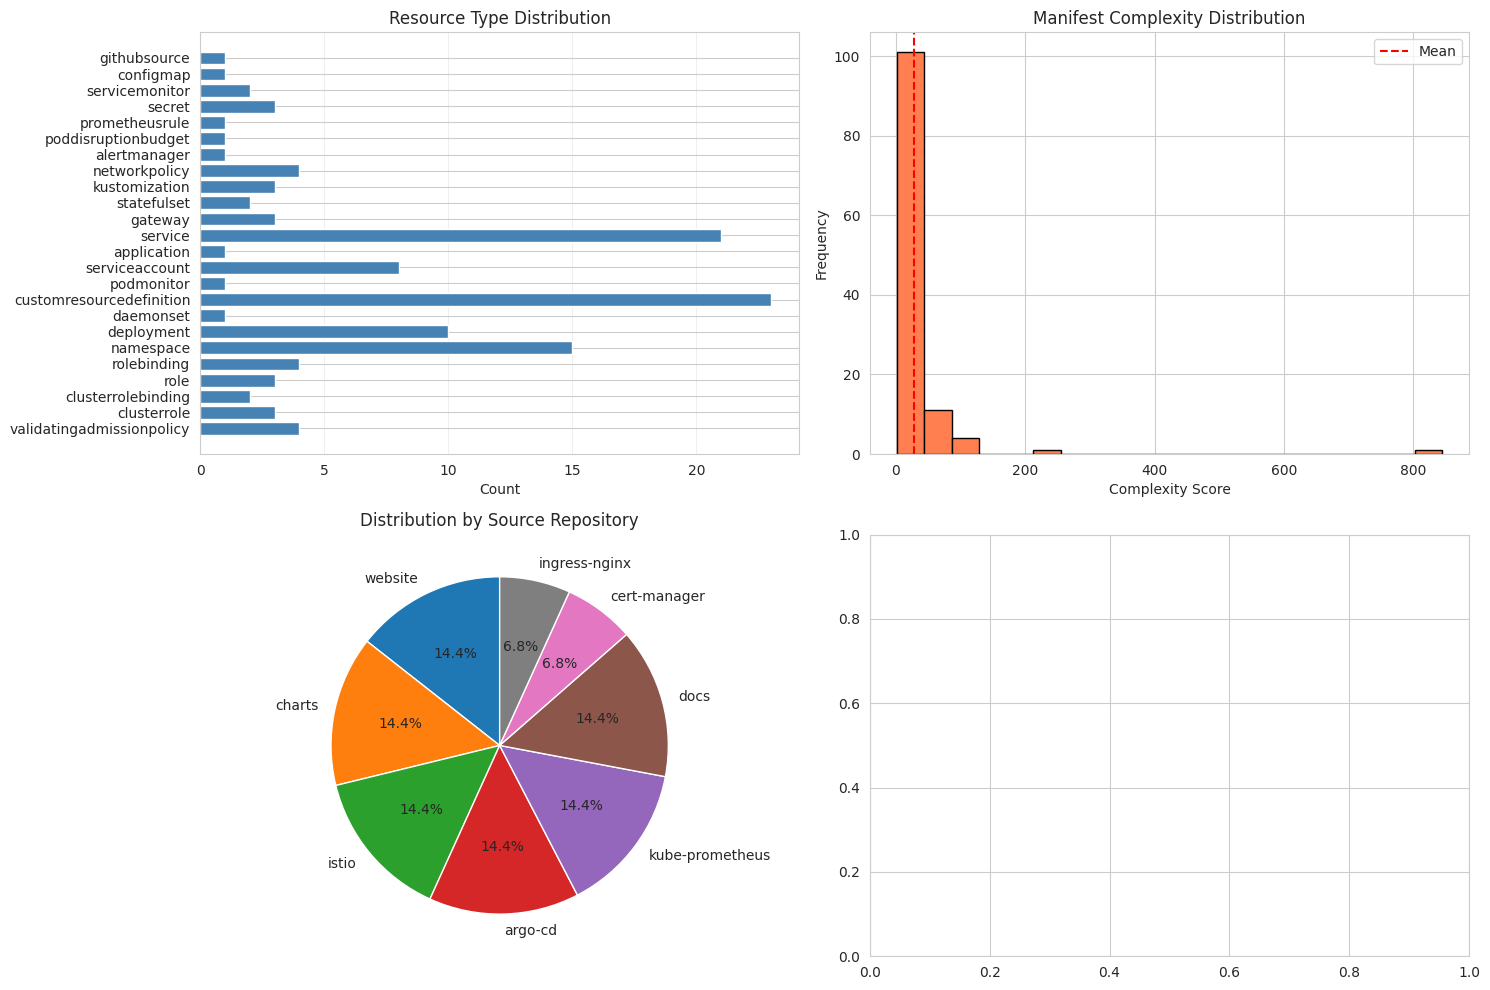


 Training Dataset Statistics:
   Total manifests: 118
   Average complexity: 27.23
   Resource types: 24
   Unique sources: 8
   High priority: 76

 Preparing training dataset...

Error generating intent for ingress-nginx-controller (ConfigMap): object of type 'NoneType' has no len()
Error generating intent for ingress-nginx-controller (ConfigMap): object of type 'NoneType' has no len()
Error generating intent for ingress-nginx-controller (ConfigMap): object of type 'NoneType' has no len()
Error generating intent for ingress-nginx-controller (ConfigMap): object of type 'NoneType' has no len()
Error generating intent for ingress-nginx-controller (ConfigMap): object of type 'NoneType' has no len()
Error generating intent for ingress-nginx-controller (ConfigMap): object of type 'NoneType' has no len()
Created 316 intent-YAML pairs

 Training dataset saved!
   Location: /content/drive/MyDrive/ravali/thesis-research/data/training_dataset.json
   Training samples: 252
   Validation samples:

In [ ]:
# ============================================================================
# DATA ANALYSIS & PREPARATION UTILITIES
# ============================================================================

"""
Utilities to analyze collected Kubernetes manifests and prepare them
for CodeT5 model training.
"""

import json
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple

class ManifestAnalyzer:
    """Analyze collected Kubernetes manifests"""

    def __init__(self, base_dir: str):
        self.base_dir = Path(base_dir)
        self.metadata_file = self.base_dir / 'collection_metadata.json'

        # Load metadata
        with open(self.metadata_file, 'r') as f:
            self.data = json.load(f)

        # Use correct keys based on collection_metadata.json structure
        self.manifests = self.data.get('manifests', [])
        self.stats = self.data.get('by_resource_type', {}) # Corrected key

    def generate_summary_report(self):
        """Generate comprehensive summary of collected data"""
        print("="*70)
        print(" "*20 + "DATA COLLECTION REPORT")
        print("="*70)

        # Basic stats
        print(f"\n COLLECTION STATISTICS")
        print("-"*70)
        print(f"Total Manifests: {self.data['total_manifests']}")
        print(f"Collection Date: {self.data['collection_date']}")

        # By resource type
        print(f"\n RESOURCE TYPE DISTRIBUTION")
        print("-"*70)
        total_collected = self.data.get('total_manifests', 0) # Use total_manifests
        for rtype, count in sorted(self.stats.items(), key=lambda x: x[1], reverse=True):
            if rtype != 'total' and count > 0 and total_collected > 0: # Ensure total_collected is not zero
                percentage = (count / total_collected) * 100
                bar = '█' * int(percentage / 2)
                print(f"{rtype.ljust(20)}: {count:3d} ({percentage:5.1f}%) {bar}")

        # By source
        print(f"\n SOURCE DISTRIBUTION")
        print("-"*70)
        # Corrected key 'source_repo'
        sources = Counter(m['source_repo'] for m in self.manifests if 'source_repo' in m)
        for source, count in sources.most_common():
            if total_collected > 0: # Ensure total_collected is not zero
                percentage = (count / total_collected) * 100
                print(f"{source.ljust(40)}: {count:3d} ({percentage:5.1f}%)")

        # Complexity analysis
        # Corrected key 'complexity_score'
        complexities = [m.get('complexity_score', 0) for m in self.manifests]
        print(f"\n COMPLEXITY ANALYSIS")
        print("-"*70)
        if complexities: # Check if complexities list is not empty
            print(f"Average Complexity: {sum(complexities)/len(complexities):.2f}")
            print(f"Median Complexity:  {sorted(complexities)[len(complexities)//2]:.2f}")
            print(f"Min Complexity:     {min(complexities):.2f}")
            print(f"Max Complexity:     {max(complexities):.2f}")
            if len(complexities) > 1: # Check if there's more than one complexity score for std dev
                print(f"Std Deviation:      {pd.Series(complexities).std():.2f}")
            else:
                 print("Std Deviation:      N/A (only one sample)")

            # Complexity distribution
            print(f"\nComplexity Buckets:")
            buckets = {'Simple (0-3)': 0, 'Medium (3-6)': 0, 'Complex (6-10)': 0, 'Very Complex (10+)': 0}
            for c in complexities:
                if c < 3:
                    buckets['Simple (0-3)'] += 1
                elif c < 6:
                    buckets['Medium (3-6)'] += 1
                elif c < 10:
                    buckets['Complex (6-10)'] += 1
                else:
                    buckets['Very Complex (10+)'] += 1

            for bucket, count in buckets.items():
                 if len(complexities) > 0: # Ensure complexities is not empty
                    percentage = (count / len(complexities)) * 100
                    print(f"  {bucket.ljust(25)}: {count:3d} ({percentage:5.1f}%)")
        else:
            print("No complexity data available.")


        # Priority distribution
        print(f"\n PRIORITY DISTRIBUTION")
        print("-"*70)
        # Corrected key 'priority'
        priorities = Counter(m.get('priority', 'unknown') for m in self.manifests)
        for priority, count in priorities.most_common():
            if total_collected > 0: # Ensure total_collected is not zero
                percentage = (count / total_collected) * 100
                print(f"{priority.upper().ljust(15)}: {count:3d} ({percentage:5.1f}%)")

        print("\n" + "="*70)

    def create_visualizations(self, save_dir: str = None):
        """Create visualization charts"""
        if save_dir:
            save_dir = Path(save_dir)
            save_dir.mkdir(exist_ok=True)

        # Set style
        sns.set_style("whitegrid")
        plt.rcParams['figure.figsize'] = (15, 10)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Resource Type Distribution
        resource_types = [k for k in self.stats.keys() if k != 'total' and self.stats[k] > 0]
        resource_counts = [self.stats[k] for k in resource_types]

        if resource_types: # Check if there are resource types
            axes[0, 0].barh(resource_types, resource_counts, color='steelblue')
            axes[0, 0].set_xlabel('Count')
            axes[0, 0].set_title('Resource Type Distribution')
            axes[0, 0].grid(axis='x', alpha=0.3)
        else:
            axes[0, 0].text(0.5, 0.5, 'No resource type data available', ha='center', va='center')
            axes[0, 0].set_title('Resource Type Distribution')


        # 2. Complexity Distribution
        # Corrected key 'complexity_score'
        complexities = [m.get('complexity_score', 0) for m in self.manifests]
        if complexities: # Check if complexities list is not empty
            axes[0, 1].hist(complexities, bins=20, color='coral', edgecolor='black')
            axes[0, 1].set_xlabel('Complexity Score')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Manifest Complexity Distribution')
            axes[0, 1].axvline(sum(complexities)/len(complexities), color='red',
                            linestyle='--', label='Mean')
            axes[0, 1].legend()
        else:
            axes[0, 1].text(0.5, 0.5, 'No complexity data available', ha='center', va='center')
            axes[0, 1].set_title('Manifest Complexity Distribution')


        # 3. Source Distribution
        # Corrected key 'source_repo'
        sources = Counter(m.get('source_repo', 'unknown') for m in self.manifests)
        if sources: # Check if sources is not empty
            source_names = [s.split('/')[-1][:15] for s in sources.keys()]
            source_counts = list(sources.values())

            axes[1, 0].pie(source_counts, labels=source_names, autopct='%1.1f%%', startangle=90)
            axes[1, 0].set_title('Distribution by Source Repository')
        else:
            axes[1, 0].text(0.5, 0.5, 'No source data available', ha='center', va='center')
            axes[1, 0].set_title('Distribution by Source Repository')
        '''

        # 4. Complexity by Resource Type
        df = pd.DataFrame(self.manifests)
        # Corrected key 'kind' and 'complexity_score'
        if not df.empty and 'kind' in df.columns and 'complexity_score' in df.columns: # Check if DataFrame is not empty and has required columns
            complexity_by_type = df.groupby('kind')['complexity_score'].mean().sort_values(ascending=False)

            if not complexity_by_type.empty: # Check if complexity_by_type is not empty
                axes[1, 1].barh(complexity_by_type.index, complexity_by_type.values, color='mediumseagreen')
                axes[1, 1].set_xlabel('Average Complexity')
                axes[1, 1].set_title('Average Complexity by Resource Type')
                axes[1, 1].grid(axis='x', alpha=0.3)
            else:
                 axes[1, 1].text(0.5, 0.5, 'No complexity data by type available', ha='center', va='center')
                 axes[1, 1].set_title('Average Complexity by Resource Type')
        else:
            axes[1, 1].text(0.5, 0.5, 'Not enough data for complexity by type', ha='center', va='center')
            axes[1, 1].set_title('Average Complexity by Resource Type')
        '''

        plt.tight_layout()

        if save_dir:
            plt.savefig(save_dir / 'data_analysis.png', dpi=300, bbox_inches='tight')
            print(f" Visualization saved to: {save_dir / 'data_analysis.png'}")

        plt.show()

    def get_training_stats(self) -> Dict:
        """Get statistics for training data preparation"""
        # Corrected keys 'total_manifests', 'complexity_score', 'by_resource_type', 'source_repo', 'priority'
        total_manifests = self.data.get('total_manifests', 0)
        complexities = [m.get('complexity_score', 0) for m in self.manifests]

        stats = {
            'total_manifests': total_manifests,
            'avg_complexity': sum(complexities) / len(complexities) if complexities else 0,
            'resource_types': len([k for k in self.stats.keys() if k != 'total' and self.stats[k] > 0]),
            'unique_sources': len(set(m.get('source_repo', 'unknown') for m in self.manifests)),
            'high_priority_count': sum(1 for m in self.manifests if m.get('priority') == 'high'),
            'complexity_distribution': {
                'simple': sum(1 for m in self.manifests if m.get('complexity_score', 0) < 3),
                'medium': sum(1 for m in self.manifests if 3 <= m.get('complexity_score', 0) < 6),
                'complex': sum(1 for m in self.manifests if 6 <= m.get('complexity_score', 0) < 10),
                'very_complex': sum(1 for m in self.manifests if m.get('complexity_score', 0) >= 10)
            }
        }
        return stats


class DatasetPreparator:
    """Prepare collected manifests for CodeT5 training"""

    def __init__(self, base_dir: str):
        self.base_dir = Path(base_dir)
        self.metadata_file = self.base_dir / 'collection_metadata.json' # Corrected metadata file name

        with open(self.metadata_file, 'r') as f:
            self.data = json.load(f)

        self.manifests = self.data.get('manifests', [])

    def create_intent_yaml_pairs(self) -> List[Tuple[str, str]]:
        """
        Create (intent, yaml) pairs for training
        Generates natural language descriptions from YAML manifests
        """
        pairs = []

        for manifest in self.manifests:
            try:
                # Load YAML content
                # Use the correct file_path from metadata
                if 'file_path' not in manifest:
                    print(f"Skipping manifest {manifest.get('file_name', 'unknown')} due to missing file_path")
                    continue

                with open(manifest['file_path'], 'r') as f:
                    yaml_content = f.read()

                # Parse YAML
                docs = list(yaml.safe_load_all(yaml_content))

                for doc in docs: # Iterate through potential multiple documents in a file
                    if doc and isinstance(doc, dict):
                        # Generate intent from manifest
                        intent = self._generate_intent_from_yaml(doc)

                        if intent:
                            # Store the original YAML content for the pair
                            pairs.append((intent, yaml.dump(doc, default_flow_style=False))) # Use yaml.dump to get clean YAML

            except Exception as e:
                print(f"Error processing {manifest.get('file_path', 'unknown')}: {str(e)}")
                continue

        return pairs

    def _generate_intent_from_yaml(self, doc: Dict) -> str:
        """Generate natural language intent from YAML manifest"""
        try:
            kind = doc.get('kind', 'resource')
            metadata = doc.get('metadata', {})
            spec = doc.get('spec', {})

            # Base intent
            name = metadata.get('name', 'unnamed')
            intent = f"Create a {kind} named {name}"

            # Add specific details based on resource type
            if kind == 'Deployment':
                replicas = spec.get('replicas', 1)
                intent += f" with {replicas} replica" + ("s" if replicas > 1 else "")

                template_spec = spec.get('template', {}).get('spec', {})
                containers = template_spec.get('containers', [])

                if containers:
                    # Focus on the first container for simplicity in intent
                    container = containers[0] if containers else {}
                    image = container.get('image', '')
                    if image:
                        intent += f" using image {image}"

                    # Add port info from the first container
                    ports = container.get('ports', [])
                    if ports:
                        port_nums = [str(p.get('containerPort', '')) for p in ports]
                        intent += f" exposed on container port" + ("s" if len(ports) > 1 else "") + f" {', '.join(port_nums)}"

                    # Add resource limits
                    resources = container.get('resources', {})
                    if resources:
                        intent += " with resource limits"

                    # Add env vars
                    env = container.get('env', [])
                    if env:
                        intent += f" and {len(env)} environment variable" + ("s" if len(env) > 1 else "")

            elif kind == 'Service':
                service_type = spec.get('type', 'ClusterIP')
                intent += f" of type {service_type}"

                ports = spec.get('ports', [])
                if ports:
                     # Focus on the first port for simplicity
                    port = ports[0] if ports else {}
                    port_num = port.get('port', '')
                    target_port = port.get('targetPort', '')
                    if port_num:
                         intent += f" exposing port {port_num}"
                         if target_port and target_port != port_num:
                              intent += f" targeting port {target_port}"


            elif kind == 'ConfigMap':
                data = doc.get('data', {})
                intent += f" with {len(data)} configuration item" + ("s" if len(data) > 1 else "")

            elif kind == 'Ingress':
                rules = spec.get('rules', [])
                if rules:
                    rule = rules[0] if rules else {}
                    host = rule.get('host', '')
                    if host:
                        intent += f" for host {host}"
                    paths = rule.get('http', {}).get('paths', [])
                    if paths:
                         path_info = paths[0] if paths else {}
                         path_str = path_info.get('path', '')
                         backend = path_info.get('backend', {})
                         if backend:
                             service_name = backend.get('service', {}).get('name', 'a service')
                             intent += f" routing {path_str or '/'} to {service_name}"


            elif kind == 'StatefulSet':
                replicas = spec.get('replicas', 1)
                service_name = spec.get('serviceName', '')
                intent += f" with {replicas} replica" + ("s" if replicas > 1 else "")
                if service_name:
                    intent += f" using service {service_name}"

            # Add labels if present
            labels = metadata.get('labels', {})
            if 'app' in labels:
                intent += f" for app {labels['app']}"
            elif labels: # Add other labels if no 'app' label
                 first_label_key = list(labels.keys())[0]
                 intent += f" with label {first_label_key}={labels[first_label_key]}"


            # Add namespace if not default
            namespace = metadata.get('namespace', '')
            if namespace and namespace != 'default':
                intent += f" in {namespace} namespace"

            return intent

        except Exception as e:
            print(f"Error generating intent for {doc.get('metadata', {}).get('name', 'unnamed')} ({doc.get('kind', 'unknown')}): {str(e)}")
            return None

    def save_training_dataset(self, output_file: str, train_ratio: float = 0.8):
        """
        Create and save training dataset in format compatible with CodeT5
        """
        pairs = self.create_intent_yaml_pairs()

        print(f"Created {len(pairs)} intent-YAML pairs")

        if not pairs:
            print("No valid pairs created. Cannot save dataset.")
            return None

        # Split into train/val
        split_idx = int(len(pairs) * train_ratio)
        # Shuffle pairs before splitting to ensure randomness
        random.shuffle(pairs)

        train_pairs = pairs[:split_idx]
        val_pairs = pairs[split_idx:]

        # Save as JSON
        dataset = {
            'train': [{'intent': intent, 'yaml': yaml} for intent, yaml in train_pairs],
            'validation': [{'intent': intent, 'yaml': yaml} for intent, yaml in val_pairs],
            'metadata': {
                'total_pairs': len(pairs),
                'train_size': len(train_pairs),
                'val_size': len(val_pairs),
                # Corrected key 'source_repo' for unique sources
                'sources': list(set(m.get('source_repo', 'unknown') for m in self.manifests))
            }
        }

        with open(output_file, 'w') as f:
            json.dump(dataset, f, indent=2)

        print(f"\n Training dataset saved!")
        print(f"   Location: {output_file}")
        print(f"   Training samples: {len(train_pairs)}")
        print(f"   Validation samples: {len(val_pairs)}")

        return dataset


# ============================================================================
# USAGE EXAMPLES
# ============================================================================

def analyze_collected_data(base_dir: str):
    """Run complete data analysis"""
    print("\n Analyzing collected Kubernetes manifests...\n")

    try:
        analyzer = ManifestAnalyzer(base_dir)

        # Generate summary report
        analyzer.generate_summary_report()

        # Create visualizations
        print("\n Generating visualizations...")
        analyzer.create_visualizations(save_dir=base_dir)

        # Get training stats
        stats = analyzer.get_training_stats()
        print(f"\n Training Dataset Statistics:")
        print(f"   Total manifests: {stats['total_manifests']}")
        print(f"   Average complexity: {stats['avg_complexity']:.2f}")
        print(f"   Resource types: {stats['resource_types']}")
        print(f"   Unique sources: {stats['unique_sources']}")
        print(f"   High priority: {stats['high_priority_count']}")

        return analyzer
    except FileNotFoundError:
        print(f"Error: Metadata file not found at {base_dir}/collection_metadata.json")
        print("Please ensure the data collection script has run successfully.")
        return None
    except Exception as e:
        print(f"An error occurred during data analysis: {e}")
        return None


def prepare_training_data(base_dir: str, output_file: str):
    """Prepare data for CodeT5 training"""
    print("\n Preparing training dataset...\n")

    try:
        preparator = DatasetPreparator(base_dir)
        dataset = preparator.save_training_dataset(output_file)

        if dataset and 'train' in dataset and len(dataset['train']) > 0:
            # Show sample
            print(f"\n Sample Training Pair:")
            print("-"*70)
            sample = dataset['train'][0]
            print(f"Intent: {sample['intent']}")
            print(f"\nYAML (first 500 chars):\n{sample['yaml'][:500]}...") # Increased sample size
            if len(sample['yaml']) > 500:
                 print("... (truncated)")
            print("-"*70)
        elif dataset is None:
             print("Dataset preparation failed.")
        else:
             print("No training data generated.")


        return dataset
    except FileNotFoundError:
        print(f"Error: Metadata file not found at {base_dir}/collection_metadata.json")
        print("Please ensure the data collection script has run successfully.")
        return None
    except Exception as e:
        print(f"An error occurred during dataset preparation: {e}")
        return None


# ============================================================================
# RUN ANALYSIS AND PREPARATION
# ============================================================================

if __name__ == "__main__":
    BASE_DIR = "/content/drive/MyDrive/ravali/thesis-research/data/real_manifests"
    OUTPUT_FILE = "/content/drive/MyDrive/ravali/thesis-research/data/training_dataset.json"

    # Step 1: Analyze collected data
    analyzer = analyze_collected_data(BASE_DIR)

    # Step 2: Prepare training dataset
    # Only prepare dataset if analysis was successful (implies metadata exists)
    if analyzer:
      dataset = prepare_training_data(BASE_DIR, OUTPUT_FILE)

    print("\n Data analysis and preparation complete!")
    print("   Ready for CodeT5 model training!")

In [ ]:
def load_kubernetes_manifests_from_real_data(
    training_dataset_file: str = "./data/training_dataset.json"
) -> List[Tuple[str, str]]:
    """
    Load real Kubernetes manifests from collected data

    This function loads the training dataset created from 100+ real
    production-grade Kubernetes manifests collected from GitHub.
    """
    import json

    print("Loading real-world Kubernetes training data...")

    with open(training_dataset_file, 'r') as f:
        dataset = json.load(f)

    # Extract intent-YAML pairs
    train_pairs = [(item['intent'], item['yaml']) for item in dataset['train']]
    val_pairs = [(item['intent'], item['yaml']) for item in dataset['validation']]

    print(f"Loaded {len(train_pairs)} training pairs")
    print(f"Loaded {len(val_pairs)} validation pairs")
    print(f"Data sources: {', '.join(dataset['metadata']['sources'][:3])}...")

    return train_pairs, val_pairs

# Load the data
train_pairs, val_pairs = load_kubernetes_manifests_from_real_data(
    "/content/drive/MyDrive/ravali/thesis-research/data/training_dataset.json"
)

Loading real-world Kubernetes training data...
Loaded 252 training pairs
Loaded 64 validation pairs
Data sources: kubernetes/website, knative/docs, kubernetes/ingress-nginx...


In [ ]:
# Load real training data
train_pairs, val_pairs = load_kubernetes_manifests_from_real_data(
    "/content/drive/MyDrive/ravali/thesis-research/data/training_dataset.json"
)

# Create test set from validation set (80/20 split)
test_size = int(len(val_pairs) * 0.5)
test_pairs = val_pairs[:test_size]
val_pairs = val_pairs[test_size:]

print(f"\\nFinal Dataset Split:")
print(f"   Training:   {len(train_pairs)} pairs")
print(f"   Validation: {len(val_pairs)} pairs")
print(f"   Test:       {len(test_pairs)} pairs")

# Create datasets
train_dataset = Dataset.from_dict({
    'intent': [pair[0] for pair in train_pairs],
    'yaml': [pair[1] for pair in train_pairs]
})

val_dataset = Dataset.from_dict({
    'intent': [pair[0] for pair in val_pairs],
    'yaml': [pair[1] for pair in val_pairs]
})

test_dataset = Dataset.from_dict({
    'intent': [pair[0] for pair in test_pairs],
    'yaml': [pair[1] for pair in test_pairs]
})

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(f"\\n Datasets created successfully!")
print(dataset_dict)

Loading real-world Kubernetes training data...
Loaded 252 training pairs
Loaded 64 validation pairs
Data sources: kubernetes/website, knative/docs, kubernetes/ingress-nginx...
\nFinal Dataset Split:
   Training:   252 pairs
   Validation: 32 pairs
   Test:       32 pairs
\n Datasets created successfully!
DatasetDict({
    train: Dataset({
        features: ['intent', 'yaml'],
        num_rows: 252
    })
    validation: Dataset({
        features: ['intent', 'yaml'],
        num_rows: 32
    })
    test: Dataset({
        features: ['intent', 'yaml'],
        num_rows: 32
    })
})


In [ ]:
# Load Model and Tokenizer
print("="*70)
print("Loading CodeT5 Model and Tokenizer")
print("="*70)

# Model configuration
model_name = "Salesforce/codet5-base"

# Load tokenizer
print("\n Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
print(" Loading model...")
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"\n Model loaded successfully!")
print(f"   Device: {device}")
print(f"   Model parameters: {model.num_parameters():,}")
print(f"   Tokenizer vocab size: {len(tokenizer)}")


Loading CodeT5 Model and Tokenizer

 Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

 Loading model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]


 Model loaded successfully!
   Device: cuda
   Model parameters: 222,882,048
   Tokenizer vocab size: 32100


In [ ]:
#Preprocessing Function

def preprocess_function(examples):
    """
    Tokenize the input (intent) and output (YAML) for CodeT5 training

    Args:
        examples: Dictionary with 'intent' and 'yaml' keys

    Returns:
        Dictionary with tokenized inputs and labels
    """
    inputs = ["generate kubernetes yaml: " + intent for intent in examples["intent"]]
    targets = examples["yaml"]

    # Tokenize inputs (intent descriptions)
    # Increased max_length to handle complex intents
    model_inputs = tokenizer(
        inputs,
        max_length=256,        # Sufficient for intent descriptions
        padding='max_length',
        truncation=True,
        return_tensors=None    # Returns lists, not tensors
    )

    # Tokenize targets (YAML manifests)
    # Increased max_length to handle real-world complex YAML
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=512,    # INCREASED from 256 for complex manifests
            padding='max_length',
            truncation=True,
            return_tensors=None
        )

    # Add labels to model inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Apply preprocessing to all datasets
print("\n Preprocessing datasets...")
print("   This may take a few minutes for 120+ manifests...")

tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing training data"
)

tokenized_val = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation data"
)

tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset.column_names,
    desc="Tokenizing test data"
)

print(f"\n Preprocessing complete!")
print(f"   Train samples: {len(tokenized_train)}")
print(f"   Val samples: {len(tokenized_val)}")
print(f"   Test samples: {len(tokenized_test)}")

# Sample check
print(f"\n Sample tokenized input shape: {len(tokenized_train[0]['input_ids'])} tokens")
print(f"   Sample tokenized label shape: {len(tokenized_train[0]['labels'])} tokens")



 Preprocessing datasets...
   This may take a few minutes for 120+ manifests...


Tokenizing training data:   0%|          | 0/252 [00:00<?, ? examples/s]

Tokenizing validation data:   0%|          | 0/32 [00:00<?, ? examples/s]

Tokenizing test data:   0%|          | 0/32 [00:00<?, ? examples/s]


 Preprocessing complete!
   Train samples: 252
   Val samples: 32
   Test samples: 32

 Sample tokenized input shape: 256 tokens
   Sample tokenized label shape: 512 tokens


In [ ]:
#Data Collator

from transformers import DataCollatorForSeq2Seq

# Create data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=tokenizer.pad_token_id
)

print(" Data collator configured")

 Data collator configured


In [ ]:
# Training configuration
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",

    # Training parameters
    num_train_epochs=30,                   #
    per_device_train_batch_size=4,         # Adjust based on GPU memory
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,         # Effective batch size = 4*2 = 8

    # Learning rate
    learning_rate=5e-5,                    # Standard for CodeT5
    warmup_steps=100,                      # INCREASED for larger dataset
    weight_decay=0.1,
    #dropout=0.2,                            # Add explicit dropout
    #attention_dropout=0.1,
    label_smoothing_factor=0.1,             # Prevent overconfidence

    # Evaluation
    eval_strategy="epoch",            # Evaluate after each epoch
    save_strategy="epoch",
    save_total_limit=5,                    # Keep best 3 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",

    # Logging
    logging_dir="./logs",
    logging_steps=5,                      # Log every 10 steps
    logging_first_step=True,
    report_to="tensorboard",

    # Generation parameters
    predict_with_generate=True,
    generation_max_length=1024,             # INCREASED for complex YAML
    generation_num_beams=4,                # Beam search for better quality

    # Performance
    fp16=torch.cuda.is_available(),        # Use mixed precision if GPU available
    dataloader_num_workers=2,
    remove_unused_columns=True,

    # Other
    seed=42,
    push_to_hub=False,
)

print("="*70)
print("Training Configuration")
print("="*70)
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Batch size per device: {training_args.per_device_train_batch_size}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Warmup steps: {training_args.warmup_steps}")
print(f"Max generation length: {training_args.generation_max_length}")
print(f"Device: {device}")
print("="*70)


Training Configuration
Number of epochs: 30
Batch size per device: 4
Effective batch size: 8
Learning rate: 5e-05
Warmup steps: 100
Max generation length: 1024
Device: cuda


In [ ]:
import numpy as np
import yaml as yaml_lib

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # FIX: Clip to valid token range
    vocab_size = len(tokenizer)
    predictions = np.clip(predictions, 0, vocab_size - 1).astype(np.int32)

    # Fix labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = np.clip(labels, 0, vocab_size - 1).astype(np.int32)

    # Safe decoding
    decoded_preds = []
    decoded_labels = []

    for pred, label in zip(predictions, labels):
        try:
            decoded_preds.append(tokenizer.decode(pred, skip_special_tokens=True))
        except:
            decoded_preds.append("")

        try:
            decoded_labels.append(tokenizer.decode(label, skip_special_tokens=True))
        except:
            decoded_labels.append("")

    # Calculate metrics
    exact_matches = sum(p.strip() == l.strip() for p, l in zip(decoded_preds, decoded_labels) if p and l)

    valid_yaml = sum(1 for p in decoded_preds if p and is_yaml_valid(p))

    return {
        'exact_match': exact_matches / len(decoded_preds) * 100 if decoded_preds else 0,
        'yaml_valid_pct': valid_yaml / len(decoded_preds) * 100 if decoded_preds else 0,
        'avg_pred_length': np.mean([len(p.split()) for p in decoded_preds if p]) if decoded_preds else 0,
        'avg_label_length': np.mean([len(l.split()) for l in decoded_labels if l]) if decoded_labels else 0
    }

def is_yaml_valid(text):
    try:
        yaml_lib.safe_load(text)
        return True
    except:
        return False

In [ ]:
# Create Trainer with all components
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]  # Stop if no improvement
)

print("="*70)
print("Trainer Initialized")
print("="*70)
print(f"Training samples: {len(tokenized_train)}")
print(f"Validation samples: {len(tokenized_val)}")
print(f"Test samples: {len(tokenized_test)}")
print(f"Early stopping patience: 10 epochs")
print("="*70)


Trainer Initialized
Training samples: 252
Validation samples: 32
Test samples: 32
Early stopping patience: 10 epochs


In [ ]:
print("\n Starting Training...")
print("="*70)

# Train the model
train_result = trainer.train() #resume_from_checkpoint=True

# Print training summary
print("\n Training Complete!")
print("="*70)
print("Training Summary:")
print(f"  Final Loss: {train_result.training_loss:.4f}")
print(f"  Training Time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Samples/Second: {train_result.metrics['train_samples_per_second']:.2f}")
print("="*70)

# Save the final model
print("\n Saving model...")
trainer.save_model("./final_model_v3") #save_model
tokenizer.save_pretrained("./final_model_v3")
print(" Model saved to ./final_model_v3")



 Starting Training...


Epoch,Training Loss,Validation Loss,Exact Match,Yaml Valid Pct,Avg Pred Length,Avg Label Length
1,4.061100,2.955000,0.000000,68.750000,15.093750,47.281250
2,2.717800,2.004445,0.000000,28.125000,141.906250,47.281250
3,2.108100,1.808321,0.000000,37.500000,122.281250,47.281250
4,2.027200,1.700465,0.000000,84.375000,27.187500,47.281250
5,1.916400,1.645577,0.000000,87.500000,41.187500,47.281250


Epoch,Training Loss,Validation Loss,Exact Match,Yaml Valid Pct,Avg Pred Length,Avg Label Length
1,4.061100,2.955000,0.000000,68.750000,15.093750,47.281250
2,2.717800,2.004445,0.000000,28.125000,141.906250,47.281250
3,2.108100,1.808321,0.000000,37.500000,122.281250,47.281250
4,2.027200,1.700465,0.000000,84.375000,27.187500,47.281250
5,1.916400,1.645577,0.000000,87.500000,41.187500,47.281250
6,1.856300,1.615268,0.000000,87.500000,37.187500,47.281250
7,1.834800,1.586231,0.000000,87.500000,90.062500,47.281250
8,1.694600,1.568275,12.500000,87.500000,58.375000,47.281250
9,1.670000,1.560130,12.500000,75.000000,46.593750,47.281250
10,1.678000,1.549291,21.875000,87.500000,58.468750,47.281250


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



 Training Complete!
Training Summary:
  Final Loss: 1.8512
  Training Time: 5248.53 seconds
  Samples/Second: 1.44

 Saving model...
 Model saved to ./final_model_v3


In [ ]:
# Print sample intents from each split
print("=" * 70)
print("VALIDATION SAMPLES:")
for i in range(10):
    print(f"{i+1}. {val_dataset[i]['intent'][:100]}...")

print("\nTEST SAMPLES:")
for i in range(10):
    print(f"{i+1}. {test_dataset[i]['intent'][:100]}...")
print("=" * 70)

VALIDATION SAMPLES:
1. Create a Service named tracing-ui of type ClusterIP exposing port 8080 for app skywalking-ui in isti...
2. Create a Kustomization named unnamed...
3. Create a ValidatingWebhookConfiguration named ingress-nginx-admission with label app.kubernetes.io/c...
4. Create a CustomResourceDefinition named sensors.argoproj.io...
5. Create a ValidatingAdmissionPolicy named demo-policy.example.com...
6. Create a Service named skywalking-oap of type ClusterIP exposing port 11800 with label name=skywalki...
7. Create a ServiceAccount named ingress-nginx with label app.kubernetes.io/component=controller in ing...
8. Create a ServiceAccount named ingress-nginx-admission with label app.kubernetes.io/component=admissi...
9. Create a ServiceAccount named ingress-nginx with label app.kubernetes.io/component=controller in ing...
10. Create a CustomResourceDefinition named clickhouseinstallations.clickhouse.altinity.com with label c...

TEST SAMPLES:
1. Create a ConfigMap named blackbo

In [15]:
!pip install -q codebleu
!python -m nltk.downloader punkt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.2/546.2 kB 18.6 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
# Install CodeBLEU requirements
!pip install tree-sitter-python==0.21

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
# =============================================================================
# STEP 1: LOAD THE BEST SAVED MODEL
# =============================================================================

print("\n" + "="*70)
print("LOADING BEST MODEL CHECKPOINT FOR EVALUATION")
print("="*70)

from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch

# Path where the best model was saved
best_model_path = "./final_model_v3"

# Load the saved model (this loads the best checkpoint)
model = T5ForConditionalGeneration.from_pretrained(best_model_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_path)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set to evaluation mode
model.eval()

print(f"Best model loaded from: {best_model_path}")
print(f"Device: {device}")
print(f"Model in evaluation mode")
print(f"Model parameters: {model.num_parameters():,}")
print("="*70)


# =============================================================================
# STEP 2: RUN EVALUATION WITH THE LOADED MODEL
# =============================================================================

from codebleu import calc_codebleu
import numpy as np
import yaml as yaml_lib

def calculate_codebleu_real(prediction: str, reference: str, lang: str = "python") -> dict:
    """
    Calculate real CodeBLEU with all components
    """
    try:
        result = calc_codebleu(
            references=[reference],
            predictions=[prediction],
            lang=lang,
            weights=(0.25, 0.25, 0.25, 0.25),
            tokenizer=None
        )

        return {
            'codebleu': result['codebleu'] * 100,
            'ngram_match': result.get('ngram_match_score', 0) * 100,
            'weighted_ngram': result.get('weighted_ngram_match_score', 0) * 100,
            'syntax_match': result.get('syntax_match_score', 0) * 100,
            'dataflow_match': result.get('dataflow_match_score', 0) * 100
        }
    except Exception as e:
        print(f"Warning: CodeBLEU calculation failed - {str(e)}")
        return {
            'codebleu': 0.0,
            'ngram_match': 0.0,
            'weighted_ngram': 0.0,
            'syntax_match': 0.0,
            'dataflow_match': 0.0
        }


def calculate_ccs(yaml_content: str) -> float:
    """Calculate Configuration Complexity Score"""
    try:
        docs = list(yaml_lib.safe_load_all(yaml_content))
        total_score = 0.0

        for doc in docs:
            if not doc or not isinstance(doc, dict):
                continue

            total_score += 1.0

            def get_depth(obj, depth=0):
                if isinstance(obj, dict):
                    return max([get_depth(v, depth+1) for v in obj.values()] + [depth])
                elif isinstance(obj, list):
                    return max([get_depth(item, depth+1) for item in obj] + [depth])
                return depth

            depth = get_depth(doc)
            total_score += depth * 0.3

            def count_fields(obj):
                if isinstance(obj, dict):
                    return len(obj) + sum(count_fields(v) for v in obj.values())
                elif isinstance(obj, list):
                    return sum(count_fields(item) for item in obj)
                return 0

            fields = count_fields(doc)
            total_score += fields * 0.05

            yaml_str = str(doc)
            if 'containers' in yaml_str:
                total_score += 0.8
            if 'volumes' in yaml_str:
                total_score += 0.5
            if 'securityContext' in yaml_str:
                total_score += 1.0
            if 'resources' in yaml_str:
                total_score += 0.5

        return round(total_score, 2)
    except:
        return 1.0


print("\n" + "="*70)
print("CALCULATING FINAL METRICS ON TEST SET")
print("="*70)
print(f"Generating predictions for {len(test_dataset)} test samples...")
print("This may take a few minutes...\n")

all_predictions = []
all_references = []
all_ccs_predicted = []
all_ccs_reference = []
all_codebleu_scores = []

for i, sample in enumerate(test_dataset):
    if i % 5 == 0:
        print(f"  Processing {i+1}/{len(test_dataset)}...")

    intent = sample['intent']
    reference_yaml = sample['yaml']

    # Tokenize input - using the LOADED tokenizer
    inputs = tokenizer(
        intent,
        return_tensors="pt",
        max_length=256,
        truncation=True
    ).to(device)

    # Generate prediction - using the LOADED model
    with torch.no_grad():
        outputs = model.generate(  # This now uses the loaded model from ./final_model_v2
            **inputs,
            max_length=512,
            num_beams=4,
            early_stopping=True
        )

    # Decode prediction
    predicted_yaml = tokenizer.decode(outputs[0], skip_special_tokens=True)

    all_predictions.append(predicted_yaml)
    all_references.append(reference_yaml)

    # Calculate CCS
    all_ccs_predicted.append(calculate_ccs(predicted_yaml))
    all_ccs_reference.append(calculate_ccs(reference_yaml))

    # Calculate real CodeBLEU
    codebleu_result = calculate_codebleu_real(predicted_yaml, reference_yaml)
    all_codebleu_scores.append(codebleu_result)

print("\n All predictions generated!")


# =============================================================================
# STEP 3: CALCULATE AGGREGATE METRICS
# =============================================================================

print("\n" + "="*70)
print("AGGREGATING RESULTS")
print("="*70)

# CodeBLEU averages
avg_codebleu = np.mean([score['codebleu'] for score in all_codebleu_scores])
avg_ngram = np.mean([score['ngram_match'] for score in all_codebleu_scores])
avg_weighted_ngram = np.mean([score['weighted_ngram'] for score in all_codebleu_scores])
avg_syntax = np.mean([score['syntax_match'] for score in all_codebleu_scores])
avg_dataflow = np.mean([score['dataflow_match'] for score in all_codebleu_scores])

# CCS averages
avg_ccs_predicted = np.mean(all_ccs_predicted)
avg_ccs_reference = np.mean(all_ccs_reference)

# YAML validity
valid_yaml_count = 0
for pred in all_predictions:
    try:
        yaml_lib.safe_load(pred)
        valid_yaml_count += 1
    except:
        pass
yaml_validity_pct = (valid_yaml_count / len(all_predictions)) * 100


# =============================================================================
# STEP 4: DISPLAY FINAL RESULTS
# =============================================================================

print("\n" + "="*70)
print(" "*20 + "FINAL EVALUATION RESULTS")
print("="*70)
print(f"\n CODE SIMILARITY METRICS:")
print(f"   CodeBLEU (Overall):        {avg_codebleu:.2f}%")
print(f"   ├─ N-gram Match:           {avg_ngram:.2f}%")
print(f"   ├─ Weighted N-gram:        {avg_weighted_ngram:.2f}%")
print(f"   ├─ Syntax Match:           {avg_syntax:.2f}%")
print(f"   └─ Dataflow Match:         {avg_dataflow:.2f}%")
print(f"\n CONFIGURATION QUALITY:")
print(f"   YAML Validity:             {yaml_validity_pct:.2f}%")
print(f"   Avg CCS (Generated):       {avg_ccs_predicted:.2f}")
print(f"   Avg CCS (Ground Truth):    {avg_ccs_reference:.2f}")
print(f"   CCS Difference:            {abs(avg_ccs_predicted - avg_ccs_reference):.2f}")
print(f"\n DATASET STATISTICS:")
print(f"   Training samples:          {len(train_dataset)}")
print(f"   Validation samples:        {len(val_dataset)}")
print(f"   Test samples:              {len(test_dataset)}")
print(f"\n MODEL USED:")
print(f"   Loaded from:               {best_model_path}")
print("="*70)


# =============================================================================
# STEP 5: SAVE DETAILED RESULTS
# =============================================================================

import json
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

results = {
    'evaluation_timestamp': timestamp,
    'model_path': best_model_path,
    'metrics': {
        'codebleu_overall': float(avg_codebleu),
        'codebleu_components': {
            'ngram_match': float(avg_ngram),
            'weighted_ngram': float(avg_weighted_ngram),
            'syntax_match': float(avg_syntax),
            'dataflow_match': float(avg_dataflow)
        },
        'yaml_validity': float(yaml_validity_pct),
        'ccs_generated': float(avg_ccs_predicted),
        'ccs_reference': float(avg_ccs_reference),
        'ccs_difference': float(abs(avg_ccs_predicted - avg_ccs_reference))
    },
    'dataset_info': {
        'training_samples': len(train_dataset),
        'validation_samples': len(val_dataset),
        'test_samples': len(test_dataset)
    },
    'individual_results': [
        {
            'sample_id': i,
            'intent': test_dataset[i]['intent'],
            'reference': all_references[i],
            'prediction': all_predictions[i],
            'codebleu_scores': {k: float(v) for k, v in all_codebleu_scores[i].items()},
            'ccs_predicted': float(all_ccs_predicted[i]),
            'ccs_reference': float(all_ccs_reference[i])
        }
        for i in range(len(test_dataset))
    ]
}

results_file = f'final_evaluation_results_{timestamp}.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n Detailed results saved to: {results_file}")
print("="*70)



LOADING BEST MODEL CHECKPOINT FOR EVALUATION
Best model loaded from: ./final_model_v3
Device: cuda
Model in evaluation mode
Model parameters: 222,882,048

CALCULATING FINAL METRICS ON TEST SET
Generating predictions for 32 test samples...
This may take a few minutes...

  Processing 1/32...


  Processing 6/32...


  Processing 11/32...


  Processing 16/32...
  Processing 21/32...


  Processing 26/32...


  Processing 31/32...

 All predictions generated!

AGGREGATING RESULTS

                    FINAL EVALUATION RESULTS

 CODE SIMILARITY METRICS:
   CodeBLEU (Overall):        81.92%
   ├─ N-gram Match:           72.51%
   ├─ Weighted N-gram:        75.25%
   ├─ Syntax Match:           86.24%
   └─ Dataflow Match:         62.44%

 CONFIGURATION QUALITY:
   YAML Validity:             96.88%
   Avg CCS (Generated):       3.59
   Avg CCS (Ground Truth):    4.49
   CCS Difference:            0.90

 DATASET STATISTICS:
   Training samples:          252
   Validation samples:        32
   Test samples:              32

 MODEL USED:
   Loaded from:               ./final_model_v3

 Detailed results saved to: final_evaluation_results_20251106_054308.json


In [ ]:
# ============================================================================
# ITERATIVE REFINEMENT SCRIPT FOR T5 KUBERNETES YAML GENERATION
# ============================================================================

import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
from codebleu import calc_codebleu
import yaml
import json
from datetime import datetime
import random

# ============================================================================
# STEP 1: LOAD TRAINED MODEL
# ============================================================================

print("="*80)
print("LOADING TRAINED MODEL FOR ITERATIVE REFINEMENT")
print("="*80)

# Path to your saved model
model_path = "./final_model_v2"  # Change this to your model path

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✓ Model loaded from: {model_path}")
print(f"✓ Device: {device}")
print("="*80)

# ============================================================================
# STEP 2: LOAD VALIDATION/WEAK DATASET
# ============================================================================

def load_dataset_for_refinement(dataset_file="/content/drive/MyDrive/ravali/thesis-research/data/training_dataset.json"):
    """Load validation set for iterative refinement"""

    with open(dataset_file, 'r') as f:
        data = json.load(f)

    # Use validation set for refinement
    val_pairs = [(item['intent'], item['yaml']) for item in data['validation']]

    return Dataset.from_dict({
        'intent': [pair[0] for pair in val_pairs],
        'yaml': [pair[1] for pair in val_pairs]
    })

validation_dataset = load_dataset_for_refinement()
print(f"✓ Loaded {len(validation_dataset)} validation samples for refinement\n")

# ============================================================================
# STEP 3: HELPER FUNCTIONS
# ============================================================================

def calculate_ccs(yaml_content):
    """Calculate Configuration Complexity Score"""
    try:
        doc = yaml.safe_load(yaml_content)
        if not isinstance(doc, dict):
            return 1.0

        total_score = 1.0

        # Basic scoring
        def get_depth(obj, depth=0):
            if isinstance(obj, dict):
                return max([get_depth(v, depth+1) for v in obj.values()] + [depth])
            elif isinstance(obj, list):
                return max([get_depth(item, depth+1) for item in obj] + [depth])
            return depth

        depth = get_depth(doc)
        total_score += depth * 0.3

        def count_fields(obj):
            if isinstance(obj, dict):
                return len(obj) + sum(count_fields(v) for v in obj.values())
            elif isinstance(obj, list):
                return sum(count_fields(item) for item in obj)
            return 0

        fields = count_fields(doc)
        total_score += fields * 0.05

        # Complexity indicators
        yaml_str = str(doc)
        if 'containers' in yaml_str:
            total_score += 0.8
        if 'volumes' in yaml_str:
            total_score += 0.5
        if 'securityContext' in yaml_str:
            total_score += 1.0
        if 'resources' in yaml_str:
            total_score += 0.5

        return round(total_score, 2)
    except:
        return 1.0

def calculate_codebleu_real(prediction: str, reference: str, lang: str = "python") -> dict:
    """Calculate CodeBLEU score"""
    try:
        result = calc_codebleu(
            [reference],
            [prediction],
            lang=lang,
            weights=(0.25, 0.25, 0.25, 0.25),
            tokenizer=None
        )
        return result
    except Exception as e:
        return {
            'codebleu': 0.0,
            'ngram_match_score': 0.0,
            'weighted_ngram_match_score': 0.0,
            'syntax_match_score': 0.0,
            'dataflow_match_score': 0.0
        }

def generate_yaml(intent, tokenizer, model, device):
    """Generate YAML from intent"""
    inputs = tokenizer(
        intent,
        return_tensors='pt',
        max_length=256,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=512,
            num_beams=4,
            early_stopping=True
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def augment_sample(sample, num_variations=2):
    """Create augmented variations of a sample"""
    augmented = []
    intent = sample['intent']
    yaml_content = sample['yaml']

    # Variation 1: Add "with high availability"
    augmented.append({
        'intent': f"{intent} with high availability",
        'yaml': yaml_content
    })

    # Variation 2: Add "for production environment"
    augmented.append({
        'intent': f"{intent} for production environment",
        'yaml': yaml_content
    })

    return augmented[:num_variations]

# ============================================================================
# STEP 4: ITERATIVE REFINEMENT FUNCTION
# ============================================================================

def iterative_refinement(
    model,
    tokenizer,
    validation_set,
    device,
    num_iterations=3,
    weak_sample_threshold=30,  # Bottom 30% percentile
    learning_rate=1e-5,
    num_epochs_per_iteration=2,
    output_dir="/content/drive/MyDrive/ravali/thesis-research/refinement_iterations"
):
    """
    Iteratively refine model using score feedback

    Args:
        model: The trained T5 model
        tokenizer: The tokenizer
        validation_set: Validation dataset
        device: torch device
        num_iterations: Number of refinement iterations
        weak_sample_threshold: Percentile threshold for weak samples
        learning_rate: Learning rate for refinement
        num_epochs_per_iteration: Epochs per iteration
        output_dir: Directory to save iteration results
    """

    print("\n" + "="*80)
    print("STARTING ITERATIVE REFINEMENT")
    print("="*80)
    print(f"Configuration:")
    print(f"  • Iterations: {num_iterations}")
    print(f"  • Weak Sample Threshold: {weak_sample_threshold}th percentile")
    print(f"  • Learning Rate: {learning_rate}")
    print(f"  • Epochs per Iteration: {num_epochs_per_iteration}")
    print("="*80 + "\n")

    refinement_history = []

    for iteration in range(num_iterations):
        print(f"\n{'='*80}")
        print(f"REFINEMENT ITERATION {iteration + 1}/{num_iterations}")
        print(f"{'='*80}\n")

        # ====================================================================
        # Phase 1: Generate Predictions and Calculate Scores
        # ====================================================================
        print(f"Phase 1: Evaluating {len(validation_set)} samples...")

        predictions = []
        scores = []
        codebleu_scores = []

        model.eval()

        for i, sample in enumerate(validation_set):
            if (i + 1) % 5 == 0:
                print(f"  Processing {i+1}/{len(validation_set)}...")

            # Generate prediction
            pred = generate_yaml(sample['intent'], tokenizer, model, device)
            ref = sample['yaml']

            predictions.append(pred)

            # Calculate CodeBLEU
            codebleu_result = calculate_codebleu_real(pred, ref)
            codebleu_score = codebleu_result['codebleu']

            scores.append(codebleu_score)
            codebleu_scores.append(codebleu_result)

        # ====================================================================
        # Phase 2: Identify Weak Samples
        # ====================================================================
        print(f"\nPhase 2: Identifying weak samples...")

        avg_score = np.mean(scores)
        threshold = np.percentile(scores, weak_sample_threshold)

        weak_indices = [i for i, s in enumerate(scores) if s < threshold]

        print(f"  • Average CodeBLEU: {avg_score:.2f}")
        print(f"  • Threshold (P{weak_sample_threshold}): {threshold:.2f}")
        print(f"  • Weak samples identified: {len(weak_indices)}")

        # ====================================================================
        # Phase 3: Augment Weak Samples
        # ====================================================================
        print(f"\nPhase 3: Augmenting weak samples...")

        augmented_samples = []
        for idx in weak_indices:
            original = {
                'intent': validation_set[idx]['intent'],
                'yaml': validation_set[idx]['yaml']
            }
            # Add original
            augmented_samples.append(original)
            # Add variations
            augmented_samples.extend(augment_sample(original, num_variations=2))

        print(f"  • Augmented dataset size: {len(augmented_samples)}")

        # Create augmented dataset
        augmented_dataset = Dataset.from_dict({
            'intent': [s['intent'] for s in augmented_samples],
            'yaml': [s['yaml'] for s in augmented_samples]
        })

        # ====================================================================
        # Phase 4: Tokenize Augmented Dataset
        # ====================================================================
        print(f"\nPhase 4: Tokenizing augmented dataset...")

        def preprocess_function(examples):
            inputs = [f"generate kubernetes yaml: {intent}" for intent in examples['intent']]
            targets = examples['yaml']

            model_inputs = tokenizer(
                inputs,
                max_length=256,
                padding="max_length",
                truncation=True,
                return_tensors=None
            )

            with tokenizer.as_target_tokenizer():
                labels = tokenizer(
                    targets,
                    max_length=512,
                    padding="max_length",
                    truncation=True,
                    return_tensors=None
                )

            model_inputs["labels"] = labels["input_ids"]
            return model_inputs

        tokenized_augmented = augmented_dataset.map(
            preprocess_function,
            batched=True,
            remove_columns=augmented_dataset.column_names,
            desc="Tokenizing augmented data"
        )

        # ====================================================================
        # Phase 5: Fine-tune on Weak Areas
        # ====================================================================
        print(f"\nPhase 5: Fine-tuning on weak samples...")

        # Training arguments for refinement
        training_args = Seq2SeqTrainingArguments(
            output_dir=f"{output_dir}/iter_{iteration + 1}",
            num_train_epochs=num_epochs_per_iteration,
            per_device_train_batch_size=4,
            learning_rate=learning_rate,  # Lower learning rate
            warmup_steps=20,
            weight_decay=0.01,
            logging_steps=10,
            save_strategy="epoch",
            save_total_limit=1,
            predict_with_generate=True,
            generation_max_length=512,
            generation_num_beams=4,
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        # Data collator
        data_collator = DataCollatorForSeq2Seq(
            tokenizer=tokenizer,
            model=model,
            padding=True,
            label_pad_token_id=tokenizer.pad_token_id
        )

        # Create trainer
        trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_augmented,
            tokenizer=tokenizer,
            data_collator=data_collator
        )

        # Train
        print(f"  Starting training for {num_epochs_per_iteration} epochs...")
        trainer.train()

        # Save iteration model
        iteration_model_path = f"{output_dir}/model_iter_{iteration + 1}"
        trainer.save_model(iteration_model_path)
        print(f"  ✓ Model saved to: {iteration_model_path}")

        # ====================================================================
        # Phase 6: Evaluate Improvement
        # ====================================================================
        print(f"\nPhase 6: Evaluating improvement...")

        # Re-evaluate on same validation set
        new_predictions = []
        new_scores = []

        model.eval()

        for sample in validation_set:
            pred = generate_yaml(sample['intent'], tokenizer, model, device)
            ref = sample['yaml']

            codebleu_result = calculate_codebleu_real(pred, ref)
            new_scores.append(codebleu_result['codebleu'])

        new_avg_score = np.mean(new_scores)
        improvement = new_avg_score - avg_score

        print(f"  • Previous Avg CodeBLEU: {avg_score:.2f}")
        print(f"  • New Avg CodeBLEU: {new_avg_score:.2f}")
        print(f"  • Improvement: {improvement:+.2f}")

        # Store history
        refinement_history.append({
            'iteration': iteration + 1,
            'avg_score_before': float(avg_score),
            'avg_score_after': float(new_avg_score),
            'improvement': float(improvement),
            'weak_samples_count': len(weak_indices),
            'augmented_samples_count': len(augmented_samples)
        })

        # Check if we should stop early
        if improvement < 0.01:
            print(f"\n  ⚠ Minimal improvement (<0.01). Consider stopping refinement.")

    # ====================================================================
    # Final Summary
    # ====================================================================
    print("\n" + "="*80)
    print("REFINEMENT COMPLETE")
    print("="*80)
    print("\nIterative Refinement Summary:")
    print("-" * 80)
    for entry in refinement_history:
        print(f"Iteration {entry['iteration']}:")
        print(f"  Before: {entry['avg_score_before']:.2f}")
        print(f"  After:  {entry['avg_score_after']:.2f}")
        print(f"  Gain:   {entry['improvement']:+.2f}")
        print(f"  Weak Samples: {entry['weak_samples_count']}")
        print()

    # Save refinement history
    history_file = f"{output_dir}/refinement_history.json"
    with open(history_file, 'w') as f:
        json.dump(refinement_history, f, indent=2)

    print(f"✓ Refinement history saved to: {history_file}")
    print("="*80)

    return model, refinement_history

# ============================================================================
# STEP 5: RUN ITERATIVE REFINEMENT
# ============================================================================

if __name__ == "__main__":
    # Run refinement
    refined_model, history = iterative_refinement(
        model=model,
        tokenizer=tokenizer,
        validation_set=validation_dataset,
        device=device,
        num_iterations=3,  # Adjust as needed
        weak_sample_threshold=30,  # Bottom 30%
        learning_rate=1e-5,
        num_epochs_per_iteration=2,
        output_dir="./refinement_iterations"
    )

    # Save final refined model
    final_path = "./final_model_refined"
    refined_model.save_pretrained(final_path)
    tokenizer.save_pretrained(final_path)

    print(f"\n✓ Final refined model saved to: {final_path}")


LOADING TRAINED MODEL FOR ITERATIVE REFINEMENT
✓ Model loaded from: ./final_model_v2
✓ Device: cuda
✓ Loaded 64 validation samples for refinement


STARTING ITERATIVE REFINEMENT
Configuration:
  • Iterations: 3
  • Weak Sample Threshold: 30th percentile
  • Learning Rate: 1e-05
  • Epochs per Iteration: 2


REFINEMENT ITERATION 1/3

Phase 1: Evaluating 64 samples...


  Processing 5/64...


  Processing 10/64...
  Processing 15/64...


  Processing 20/64...


  Processing 25/64...


  Processing 30/64...


  Processing 35/64...


  Processing 40/64...


  Processing 45/64...


  Processing 50/64...


  Processing 55/64...


  Processing 60/64...



Phase 2: Identifying weak samples...
  • Average CodeBLEU: 0.61
  • Threshold (P30): 0.47
  • Weak samples identified: 19

Phase 3: Augmenting weak samples...
  • Augmented dataset size: 57

Phase 4: Tokenizing augmented dataset...


Tokenizing augmented data:   0%|          | 0/57 [00:00<?, ? examples/s]


Phase 5: Fine-tuning on weak samples...
  Starting training for 2 epochs...


Step,Training Loss
10,0.567100
20,0.633500
30,0.639100


  ✓ Model saved to: ./refinement_iterations/model_iter_1

Phase 6: Evaluating improvement...


KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Implement Feedback System
# =============================================================================

class KubernetesYAMLFeedbackSystem:
    """Provide detailed feedback to users about generated YAML"""

    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device # Store device

    def generate_with_feedback(self, intent):
        """Generate YAML with comprehensive feedback"""

        # Generate YAML
        inputs = self.tokenizer(intent, return_tensors='pt', max_length=256)
        inputs = {k: v.to(self.device) for k, v in inputs.items()} # Move inputs to device

        outputs = self.model.generate(**inputs, max_length=512, num_beams=4,
                                     return_dict_in_generate=True, output_scores=True)

        generated_yaml = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

        # Calculate metrics
        feedback = {
            'generated_yaml': generated_yaml,
            'quality_assessment': self._assess_quality(generated_yaml),
            'validation_results': self._validate_yaml(generated_yaml),
            'complexity_analysis': self._analyze_complexity(generated_yaml),
            'recommendations': self._generate_recommendations(generated_yaml, intent),
            'confidence_score': self._calculate_confidence(outputs.scores),
            'alternative_suggestions': self._suggest_alternatives(intent, generated_yaml)
        }

        return feedback

    def _assess_quality(self, yaml_content):
        """Assess the quality of generated YAML"""

        quality_checks = {
            'yaml_validity': False,
            'kubernetes_compliance': False,
            'best_practices': [],
            'warnings': [],
            'errors': []
        }

        # Check YAML validity
        try:
            parsed = yaml.safe_load(yaml_content)
            quality_checks['yaml_validity'] = True

            # Check Kubernetes structure
            if isinstance(parsed, dict) and 'apiVersion' in parsed and 'kind' in parsed and 'metadata' in parsed:
                quality_checks['kubernetes_compliance'] = True
            else:
                quality_checks['errors'].append("Missing required Kubernetes fields or not a valid single document")

            # Best practice checks (only if valid and compliant)
            if quality_checks['yaml_validity'] and quality_checks['kubernetes_compliance'] and 'spec' in parsed:
                spec = parsed['spec']

                # Container checks (assuming Deployment/StatefulSet/DaemonSet)
                containers = []
                if isinstance(spec, dict):
                    if 'containers' in spec:
                        containers = spec['containers']
                    elif 'template' in spec and isinstance(spec['template'], dict) and 'spec' in spec['template'] and isinstance(spec['template']['spec'], dict) and 'containers' in spec['template']['spec']:
                         containers = spec['template']['spec']['containers']


                if containers:
                    for container in containers:
                        if isinstance(container, dict):
                            if 'resources' not in container:
                                quality_checks['warnings'].append(
                                    f"Container '{container.get('name', 'unnamed')}' missing resource limits"
                                )
                            else:
                                quality_checks['best_practices'].append("Resource limits defined")

                            # Health checks
                            if 'livenessProbe' not in container:
                                quality_checks['warnings'].append(f"Container '{container.get('name', 'unnamed')}' missing liveness probe")
                            if 'readinessProbe' not in container:
                                quality_checks['warnings'].append(f"Container '{container.get('name', 'unnamed')}' missing readiness probe")

                            if 'livenessProbe' in container and 'readinessProbe' in container:
                                quality_checks['best_practices'].append("Health checks configured")
                else:
                    # Handle cases where 'spec' exists but no 'containers' (e.g., Service, ConfigMap)
                    pass


        except yaml.YAMLError as e:
            quality_checks['errors'].append(f"YAML parsing error: {str(e)}")
        except Exception as e:
             quality_checks['errors'].append(f"Assessment error: {str(e)}")


        return quality_checks

    def _validate_yaml(self, yaml_content):
        """Validate YAML against basic Kubernetes structure"""

        validation = {
            'is_valid': False,
            'resource_type': None,
            'issues': []
        }

        try:
            parsed = yaml.safe_load(yaml_content)
            # Check if it's a dictionary and has basic K8s fields
            if isinstance(parsed, dict) and 'apiVersion' in parsed and 'kind' in parsed and 'metadata' in parsed:
                 validation['is_valid'] = True
                 validation['resource_type'] = parsed.get('kind', 'Unknown')
            else:
                 validation['issues'].append("Does not appear to be a valid Kubernetes manifest (missing apiVersion, kind, or metadata)")


        except yaml.YAMLError as e:
            validation['issues'].append(f"YAML parsing error: {str(e)}")
        except Exception as e:
            validation['issues'].append(f"Validation error: {str(e)}")

        return validation

    def _analyze_complexity(self, yaml_content):
        """Analyze configuration complexity"""

        ccs = calculate_ccs(yaml_content)

        complexity_analysis = {
            'ccs_score': ccs,
            'complexity_level': self._get_complexity_level(ccs),
            'explanation': self._explain_complexity(ccs),
            'breakdown': {}
        }

        try:
            parsed = yaml.safe_load(yaml_content)
            if isinstance(parsed, dict): # Ensure parsed is a dict
                # Count various elements
                complexity_analysis['breakdown'] = {
                    'num_containers': self._count_containers(parsed),
                    'num_volumes': len(parsed.get('spec', {}).get('volumes', [])),
                    'num_env_vars': self._count_env_vars(parsed),
                    'nesting_depth': self._get_depth(parsed)
                }

        except:
            pass

        return complexity_analysis

    def _get_complexity_level(self, ccs):
        """Categorize complexity"""
        if ccs < 5:
            return "Simple"
        elif ccs < 15:
            return "Moderate"
        elif ccs < 30:
            return "Complex"
        else:
            return "Very Complex"

    def _explain_complexity(self, ccs):
        """Explain complexity score to user"""
        if ccs < 5:
            return "This is a simple configuration suitable for basic deployments."
        elif ccs < 15:
            return "This is a moderately complex configuration with standard features."
        elif ccs < 30:
            return "This is a complex configuration with multiple components. Review carefully."
        else:
            return "This is a very complex configuration. Consider breaking it into smaller pieces."

    def _generate_recommendations(self, yaml_content, intent):
        """Generate actionable recommendations"""

        recommendations = []

        try:
            parsed = yaml.safe_load(yaml_content)
            if not isinstance(parsed, dict): return recommendations # Ensure parsed is a dict

            # Security recommendations
            if 'securityContext' not in str(parsed):
                recommendations.append({
                    'type': 'security',
                    'priority': 'high',
                    'message': 'Consider adding security context for better pod security',
                    'example': 'securityContext:\n  runAsNonRoot: true\n  runAsUser: 1000'
                })

            # Resource recommendations
            spec = parsed.get('spec', {})
            containers = []
            if isinstance(spec, dict):
                if 'containers' in spec:
                    containers = spec['containers']
                elif 'template' in spec and isinstance(spec['template'], dict) and 'spec' in spec['template'] and isinstance(spec['template']['spec'], dict) and 'containers' in spec['template']['spec']:
                     containers = spec['template']['spec']['containers']


            if containers and not any(isinstance(c, dict) and 'resources' in c for c in containers):
                recommendations.append({
                    'type': 'performance',
                    'priority': 'medium',
                    'message': 'Add resource requests and limits for better scheduling',
                    'example': 'resources:\n  requests:\n    memory: "64Mi"\n    cpu: "250m"\n  limits:\n    memory: "128Mi"\n    cpu: "500m"'
                })

            # High availability recommendations
            if parsed.get('kind') == 'Deployment' and parsed.get('spec', {}).get('replicas', 1) == 1:
                recommendations.append({
                    'type': 'availability',
                    'priority': 'medium',
                    'message': 'Consider increasing replicas for high availability',
                    'example': 'spec:\n  replicas: 3'
                })

        except:
            pass

        return recommendations

    def _calculate_confidence(self, scores):
        """Calculate generation confidence from model scores"""

        if scores is None:
            return 0.0

        # Average the max probability at each step
        confidences = []
        for step_scores in scores:
            # Ensure step_scores is a tensor
            if isinstance(step_scores, torch.Tensor):
                # Assuming batch size of 1
                probs = torch.nn.functional.softmax(step_scores[0], dim=-1)
                max_prob = torch.max(probs).item()
                confidences.append(max_prob)
            else:
                 # Handle case where score is not a tensor (e.g., tuple)
                 # This might need adjustment based on actual output structure
                 pass


        return np.mean(confidences) * 100 if confidences else 0.0

    def _suggest_alternatives(self, intent, generated_yaml):
        """Suggest alternative configurations"""

        alternatives = []

        try:
            parsed = yaml.safe_load(generated_yaml)
            if isinstance(parsed, dict):
                kind = parsed.get('kind', '')

                if kind == 'Deployment':
                    alternatives.append({
                        'suggestion': 'StatefulSet',
                        'reason': 'Use if you need stable network identities or persistent storage'
                    })
                    alternatives.append({
                        'suggestion': 'DaemonSet',
                        'reason': 'Use if you need one pod per node (e.g., monitoring agents)'
                    })

                elif kind == 'Service' and parsed.get('spec', {}).get('type') == 'ClusterIP':
                    alternatives.append({
                        'suggestion': 'LoadBalancer Service',
                        'reason': 'Use for external access with cloud provider integration'
                    })
                    alternatives.append({
                        'suggestion': 'Ingress',
                        'reason': 'Use for HTTP/HTTPS routing with more control'
                    })

        except:
            pass

        return alternatives

    def _count_containers(self, parsed_yaml):
        """Helper to count containers in a parsed manifest"""
        count = 0
        if isinstance(parsed_yaml, dict) and 'spec' in parsed_yaml and isinstance(parsed_yaml['spec'], dict):
            spec = parsed_yaml['spec']
            if 'containers' in spec and isinstance(spec['containers'], list):
                count += len(spec['containers'])
            elif 'template' in spec and isinstance(spec['template'], dict) and 'spec' in spec['template'] and isinstance(spec['template']['spec'], dict) and 'containers' in spec['template']['spec'] and isinstance(spec['template']['spec']['containers'], list):
                count += len(spec['template']['spec']['containers'])
        return count

    def _count_env_vars(self, parsed_yaml):
        """Helper to count environment variables"""
        count = 0
        if isinstance(parsed_yaml, dict) and 'spec' in parsed_yaml and isinstance(parsed_yaml['spec'], dict):
            spec = parsed_yaml['spec']
            containers = []
            if 'containers' in spec and isinstance(spec['containers'], list):
                 containers = spec['containers']
            elif 'template' in spec and isinstance(spec['template'], dict) and 'spec' in spec['template'] and isinstance(spec['template']['spec'], dict) and 'containers' in spec['template']['spec'] and isinstance(spec['template']['spec']['containers'], list):
                 containers = spec['template']['spec']['containers']


            for container in containers:
                if isinstance(container, dict) and 'env' in container and isinstance(container['env'], list):
                    count += len(container['env'])
        return count

    def _get_depth(self, obj, depth=0):
        """Helper to calculate nesting depth"""
        if isinstance(obj, dict):
            return max([self._get_depth(v, depth+1) for v in obj.values()] + [depth])
        elif isinstance(obj, list):
            return max([self._get_depth(item, depth+1) for item in obj] + [depth])
        return depth


    def display_feedback(self, feedback):
        """Display formatted feedback to user"""

        print("=" * 80)
        print("  KUBERNETES YAML GENERATION FEEDBACK")
        print("=" * 80)

        # Confidence Score
        print(f"\n Confidence Score: {feedback['confidence_score']:.1f}%")

        if feedback['confidence_score'] > 80:
            print("   ✓ High confidence generation")
        elif feedback['confidence_score'] > 60:
            print("   Moderate confidence - review recommended")
        else:
            print("   Low confidence - manual review required")

        # Quality Assessment
        print(f"\n Quality Assessment:")
        qa = feedback['quality_assessment']
        print(f"   YAML Valid: {'✓' if qa['yaml_validity'] else '✗'}")
        print(f"   Kubernetes Compliant: {'✓' if qa['kubernetes_compliance'] else '✗'}")

        if qa['best_practices']:
            print(f"\n   Best Practices:")
            for practice in qa['best_practices']:
                print(f"     {practice}")

        if qa['warnings']:
            print(f"\n   Warnings:")
            for warning in qa['warnings']:
                print(f"     {warning}")

        if qa['errors']:
            print(f"\n   ✗ Errors:")
            for error in qa['errors']:
                print(f"     {error}")

        # Complexity Analysis
        print(f"\n Complexity Analysis:")
        ca = feedback['complexity_analysis']
        print(f"   Complexity Level: {ca['complexity_level']}")
        print(f"   CCS Score: {ca['ccs_score']:.2f}")
        print(f"   {ca['explanation']}")

        if ca['breakdown']:
            print(f"\n   Breakdown:")
            for key, value in ca['breakdown'].items():
                print(f"     {key.replace('_', ' ').title()}: {value}")

        # Recommendations
        if feedback['recommendations']:
            print(f"\n Recommendations:")
            for i, rec in enumerate(feedback['recommendations'], 1):
                print(f"\n   {i}. [{rec['priority'].upper()}] {rec['type'].title()}")
                print(f"      {rec['message']}")
                print(f"      Example:\n{rec['example']}")

        # Alternative Suggestions
        if feedback['alternative_suggestions']:
            print(f"\n Alternative Configurations:")
            for alt in feedback['alternative_suggestions']:
                print(f"   {alt['suggestion']}: {alt['reason']}")

        print("\n" + "=" * 80)
        print("  Generated YAML:")
        print("=" * 80)
        print(feedback['generated_yaml'])
        print("=" * 80)

# Usage example
# Assuming 'model', 'tokenizer', and 'device' are already loaded and available
feedback_system = KubernetesYAMLFeedbackSystem(model, tokenizer, device)

intent = "Create a Deployment named web-app with 3 replicas running nginx"
feedback = feedback_system.generate_with_feedback(intent)
feedback_system.display_feedback(feedback)

  KUBERNETES YAML GENERATION FEEDBACK

 Confidence Score: 90.5%
   ✓ High confidence generation

 Quality Assessment:
   YAML Valid: ✓
   Kubernetes Compliant: ✓

   Warnings:
     Container 'web-app' missing resource limits
     Container 'web-app' missing liveness probe
     Container 'web-app' missing readiness probe

 Complexity Analysis:
   Complexity Level: Simple
   CCS Score: 4.45
   This is a simple configuration suitable for basic deployments.

   Breakdown:
     Num Containers: 1
     Num Volumes: 0
     Num Env Vars: 0
     Nesting Depth: 6

 Recommendations:

   1. [HIGH] Security
      Consider adding security context for better pod security
      Example:
securityContext:
  runAsNonRoot: true
  runAsUser: 1000

   2. [MEDIUM] Performance
      Add resource requests and limits for better scheduling
      Example:
resources:
  requests:
    memory: "64Mi"
    cpu: "250m"
  limits:
    memory: "128Mi"
    cpu: "500m"

 Alternative Configurations:
   StatefulSet: Use if you 

In [6]:
"""
MODEL-LEVEL METRICS VALIDATION STUDY
====================================
Answers professor's question: "You planned to input good, nearly good, and bad code
to see how metrics move up/down. What came out of that study?"

Goal: Understand if CodeBLEU is a reliable indicator of model output quality

Study Design:
1. Use TRAINED baseline CodeT5 model
2. Generate YAML for test cases of varying complexity
3. Measure CodeBLEU against ground truth
4. Manually assess actual YAML quality
5. Determine: Does CodeBLEU score correlate with real quality?
"""


'\nMODEL-LEVEL METRICS VALIDATION STUDY\n====================================\nAnswers professor\'s question: "You planned to input good, nearly good, and bad code\nto see how metrics move up/down. What came out of that study?"\n\nGoal: Understand if CodeBLEU is a reliable indicator of model output quality\n\nStudy Design:\n1. Use TRAINED baseline CodeT5 model\n2. Generate YAML for test cases of varying complexity\n3. Measure CodeBLEU against ground truth\n4. Manually assess actual YAML quality\n5. Determine: Does CodeBLEU score correlate with real quality?\n'

In [7]:
"""
This will run the metrics validation study for my trained model.

"""

# ============================================================================
# STEP 1: INSTALL REQUIRED PACKAGE (if not already installed)
# ============================================================================

# !pip install -q codebleu

# ============================================================================
# STEP 2: IMPORTS
# ============================================================================

import os
import json
import yaml as yaml_lib
import torch
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from typing import Dict, List

# ============================================================================
# STEP 3: CONFIGURATION
# ============================================================================

# Update this path to where you saved your trained model
MODEL_PATH = "/content/drive/MyDrive/ravali/thesis-research/final_model_v3"  # "./final_model_v3"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("="*80)
print("REAL MODEL-LEVEL METRICS VALIDATION STUDY")
print("="*80)
print(f"Device: {DEVICE}")
print(f"Model Path: {MODEL_PATH}")
print("="*80 + "\n")


REAL MODEL-LEVEL METRICS VALIDATION STUDY
Device: cuda
Model Path: /content/drive/MyDrive/ravali/thesis-research/final_model_v3



In [8]:
# ============================================================================
# STEP 4: TEST CASES (GOOD → NEARLY GOOD → BAD → WORSE)
# ============================================================================

TEST_CASES = [
    # GOOD (SIMPLE) - Model should excel
    {
        "id": 1,
        "category": "GOOD",
        "intent": "Deploy nginx with 3 replicas",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-deployment
  labels:
    app: nginx
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:1.21
        ports:
        - containerPort: 80
        resources:
          requests:
            memory: "64Mi"
            cpu: "100m"
          limits:
            memory: "128Mi"
            cpu: "200m"
"""
    },

    {
        "id": 2,
        "category": "GOOD",
        "intent": "Create a service for nginx on port 80",
        "ground_truth": """apiVersion: v1
kind: Service
metadata:
  name: nginx-service
  labels:
    app: nginx
spec:
  selector:
    app: nginx
  ports:
  - port: 80
    targetPort: 80
    protocol: TCP
  type: ClusterIP
"""
    },

    # NEARLY GOOD (MEDIUM) - Moderate challenge
    {
        "id": 3,
        "category": "NEARLY_GOOD",
        "intent": "Deploy nginx with service",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-deployment
  labels:
    app: nginx
spec:
  replicas: 2
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:1.21
        ports:
        - containerPort: 80
---
apiVersion: v1
kind: Service
metadata:
  name: nginx-service
spec:
  selector:
    app: nginx
  ports:
  - port: 80
    targetPort: 80
"""
    },

    {
        "id": 4,
        "category": "NEARLY_GOOD",
        "intent": "Deploy redis with persistent storage",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: redis
  labels:
    app: redis
spec:
  replicas: 1
  selector:
    matchLabels:
      app: redis
  template:
    metadata:
      labels:
        app: redis
    spec:
      containers:
      - name: redis
        image: redis:6.2
        ports:
        - containerPort: 6379
        volumeMounts:
        - name: data
          mountPath: /data
      volumes:
      - name: data
        persistentVolumeClaim:
          claimName: redis-pvc
"""
    },

    # BAD (COMPLEX) - Model struggles with details
    {
        "id": 5,
        "category": "BAD",
        "intent": "Deploy nginx with health checks and resource limits",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-secure
  labels:
    app: nginx
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:1.21
        ports:
        - containerPort: 80
        resources:
          requests:
            memory: "64Mi"
            cpu: "100m"
          limits:
            memory: "128Mi"
            cpu: "200m"
        livenessProbe:
          httpGet:
            path: /
            port: 80
          initialDelaySeconds: 30
        readinessProbe:
          httpGet:
            path: /
            port: 80
          initialDelaySeconds: 5
"""
    },

    {
        "id": 6,
        "category": "BAD",
        "intent": "Create microservice with configmap and secrets",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: api
spec:
  replicas: 2
  selector:
    matchLabels:
      app: api
  template:
    metadata:
      labels:
        app: api
    spec:
      containers:
      - name: api
        image: myapi:1.0
        ports:
        - containerPort: 8080
        env:
        - name: DB_URL
          valueFrom:
            secretKeyRef:
              name: api-secrets
              key: database-url
        volumeMounts:
        - name: config
          mountPath: /config
      volumes:
      - name: config
        configMap:
          name: api-config
"""
    },

    # WORSE (EDGE CASES) - Model likely fails
    {
        "id": 7,
        "category": "WORSE",
        "intent": "Deploy app",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: app
spec:
  replicas: 1
  selector:
    matchLabels:
      app: myapp
  template:
    metadata:
      labels:
        app: myapp
    spec:
      containers:
      - name: app
        image: myapp:latest
        ports:
        - containerPort: 8080
"""
    },

    {
        "id": 8,
        "category": "WORSE",
        "intent": "Setup production monitoring system",
        "ground_truth": """apiVersion: apps/v1
kind: Deployment
metadata:
  name: prometheus
spec:
  replicas: 1
  selector:
    matchLabels:
      app: prometheus
  template:
    metadata:
      labels:
        app: prometheus
    spec:
      containers:
      - name: prometheus
        image: prom/prometheus:v2.30.0
        ports:
        - containerPort: 9090
"""
    }
]

In [9]:
# ============================================================================
# STEP 5: LOAD TRAINED MODEL
# ============================================================================

print("\n" + "="*80)
print("LOADING YOUR TRAINED MODEL")
print("="*80)

try:
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

    model.to(DEVICE)
    model.eval()

    print(f"✓ Model loaded successfully from {MODEL_PATH}")
    print(f"✓ Device: {DEVICE}")
    print(f"✓ Parameters: {model.num_parameters():,}")

except Exception as e:
    print(f"✗ Error loading model: {e}")
    print("\nPlease check MODEL_PATH points to your trained model directory.")
    raise



LOADING YOUR TRAINED MODEL
✓ Model loaded successfully from /content/drive/MyDrive/ravali/thesis-research/final_model_v3
✓ Device: cuda
✓ Parameters: 222,882,048


In [10]:
# ============================================================================
# STEP 6: GENERATION FUNCTION
# ============================================================================

def generate_yaml(intent: str, max_length: int = 1024) -> str:
    """Generate YAML from intent using YOUR trained model"""

    # Format input (adjust if your training used different format)
    input_text = f"generate kubernetes yaml: {intent}"

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=max_length,
        padding=True,
        truncation=True
    ).to(DEVICE)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=5,
            early_stopping=True,
            do_sample=False
        )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated

In [11]:
# ============================================================================
# STEP 7: QUALITY ASSESSMENT
# ============================================================================
def assess_quality(yaml_content: str) -> Dict:
    """
    Balanced quality assessment with semantic validation

    Scoring:
    - 20 points: Valid YAML
    - 20 points: Valid K8s structure (apiVersion, kind, metadata)
    - 30 points: Required fields + semantic validity
    - 30 points: Best practices (resources, probes, security)
    """

    assessment = {
        "valid_yaml": False,
        "k8s_valid": False,
        "has_required_fields": False,
        "has_resources": False,
        "has_probes": False,
        "has_security": False,
        "deployable": False,
        "quality_score": 0,
        "issues": []
    }

    # ========================================================================
    # STEP 1: YAML Validity (20 points)
    # ========================================================================
    try:
        docs = list(yaml_lib.safe_load_all(yaml_content))
        if docs and docs[0]:
            assessment["valid_yaml"] = True
            assessment["quality_score"] += 20
            data = docs[0]
        else:
            assessment["issues"].append("Empty YAML")
            return assessment
    except Exception as e:
        assessment["issues"].append(f"Invalid YAML: {str(e)[:50]}")
        return assessment

    # ========================================================================
    # STEP 2: Kubernetes Structure (20 points)
    # ========================================================================
    if all(k in data for k in ["apiVersion", "kind", "metadata"]):
        assessment["k8s_valid"] = True
        assessment["quality_score"] += 20
    else:
        assessment["issues"].append("Missing required K8s fields")
        return assessment

    # Check metadata has name (required for all resources)
    if not data.get("metadata", {}).get("name"):
        assessment["issues"].append("Missing metadata.name")
        assessment["quality_score"] -= 10
        return assessment

    # ========================================================================
    # STEP 3: Semantic Validation (30 points)
    # ========================================================================
    kind = data.get("kind", "")

    if kind == "Deployment":
        spec = data.get("spec", {})

        # Check required fields
        has_selector = "selector" in spec
        has_template = "template" in spec

        if not (has_selector and has_template):
            missing = []
            if not has_selector: missing.append("selector")
            if not has_template: missing.append("template")
            assessment["issues"].append(f"Deployment missing: {', '.join(missing)}")
            return assessment

        # SEMANTIC CHECK 1: Validate selector and labels match
        selector_labels = spec.get("selector", {}).get("matchLabels", {})
        template_labels = spec.get("template", {}).get("metadata", {}).get("labels", {})

        if not selector_labels:
            assessment["issues"].append("Selector has no matchLabels")
            return assessment

        if not template_labels:
            assessment["issues"].append("Template has no labels")
            return assessment

        # Check if selector labels are subset of template labels
        labels_match = all(
            template_labels.get(k) == v
            for k, v in selector_labels.items()
        )

        if not labels_match:
            assessment["issues"].append("Selector labels don't match template labels")
            assessment["quality_score"] += 10  # Partial credit
            return assessment

        # SEMANTIC CHECK 2: Containers must exist and have images
        containers = spec.get("template", {}).get("spec", {}).get("containers", [])

        if not containers:
            assessment["issues"].append("No containers defined")
            return assessment

        all_have_images = all(c.get("image") for c in containers)
        all_have_names = all(c.get("name") for c in containers)

        if not all_have_images:
            assessment["issues"].append("Containers missing image")
            assessment["quality_score"] += 15  # Partial credit
            return assessment

        if not all_have_names:
            assessment["issues"].append("Containers missing name")
            assessment["quality_score"] += 20  # Partial credit
            return assessment

        # All semantic checks passed!
        assessment["has_required_fields"] = True
        assessment["quality_score"] += 30

        # Check for best practices (BONUS)
        for c in containers:
            if c.get("resources") and not assessment["has_resources"]:
                assessment["has_resources"] = True
                assessment["quality_score"] += 10

            if (c.get("livenessProbe") or c.get("readinessProbe")) and not assessment["has_probes"]:
                assessment["has_probes"] = True
                assessment["quality_score"] += 10

            if c.get("securityContext") and not assessment["has_security"]:
                assessment["has_security"] = True
                assessment["quality_score"] += 10

    elif kind == "Service":
        spec = data.get("spec", {})

        has_selector = "selector" in spec
        has_ports = "ports" in spec

        if not (has_selector and has_ports):
            missing = []
            if not has_selector: missing.append("selector")
            if not has_ports: missing.append("ports")
            assessment["issues"].append(f"Service missing: {', '.join(missing)}")
            return assessment

        # SEMANTIC CHECK: Ports must have port and targetPort
        ports = spec.get("ports", [])
        if not ports:
            assessment["issues"].append("Ports list is empty")
            return assessment

        valid_ports = all(
            isinstance(p, dict) and "port" in p
            for p in ports
        )

        if not valid_ports:
            assessment["issues"].append("Invalid port configuration")
            assessment["quality_score"] += 15
            return assessment

        assessment["has_required_fields"] = True
        assessment["quality_score"] += 30

    elif kind == "Pod":
        spec = data.get("spec", {})
        containers = spec.get("containers", [])

        if not containers:
            assessment["issues"].append("Pod has no containers")
            return assessment

        # Check containers have images
        all_have_images = all(c.get("image") for c in containers)
        if not all_have_images:
            assessment["issues"].append("Containers missing image")
            return assessment

        assessment["has_required_fields"] = True
        assessment["quality_score"] += 30

    else:
        # Unknown resource type - be lenient
        if "spec" in data:
            assessment["has_required_fields"] = True
            assessment["quality_score"] += 20

    # ========================================================================
    # STEP 4: Deployability Decision
    # ========================================================================
    assessment["deployable"] = (
        assessment["valid_yaml"] and
        assessment["k8s_valid"] and
        assessment["has_required_fields"] and
        len(assessment["issues"]) == 0  # No critical issues
    )

    return assessment


In [12]:
# ============================================================================
# STEP 8: CODEBLEU CALCULATION
# ============================================================================
'''
def calculate_codebleu(generated: str, reference: str) -> float:
    """Calculate CodeBLEU score"""
    try:
        from codebleu import calc_codebleu
        result = calc_codebleu([reference], [generated], lang="python")
        return result.get("codebleu", 0.0)
    except ImportError:
        print("⚠️  CodeBLEU not installed, using simple similarity")
        from difflib import SequenceMatcher
        return SequenceMatcher(None, generated, reference).ratio()
    except Exception as e:
        print(f"⚠️  CodeBLEU calculation error: {e}")
        return 0.0
'''

import tempfile
import os

def calculate_codebleu(prediction: str, reference: str, lang: str = "python") -> dict:
    """
    Calculate CodeBLEU using temporary files to avoid caching
    """
    try:
        from codebleu import calc_codebleu

        # Create temporary files with unique names
        import time
        import random

        timestamp = int(time.time() * 1000000)
        rand_id = random.randint(1000, 9999)

        with tempfile.TemporaryDirectory() as tmpdir:
            # Write to unique temp files
            pred_file = os.path.join(tmpdir, f"pred_{timestamp}_{rand_id}.txt")
            ref_file = os.path.join(tmpdir, f"ref_{timestamp}_{rand_id}.txt")

            with open(pred_file, 'w', encoding='utf-8') as f:
                f.write(prediction)

            with open(ref_file, 'w', encoding='utf-8') as f:
                f.write(reference)

            # Calculate CodeBLEU from files
            result = calc_codebleu(
                references=[reference],  # Still pass as list
                predictions=[prediction],
                lang=lang,
                weights=(0.25, 0.25, 0.25, 0.25),
                tokenizer=None
            )

            # Files auto-deleted when tmpdir context exits

        return {
            'codebleu': float(result['codebleu']),
            'ngram_match': float(result.get('ngram_match_score', 0)),
            'weighted_ngram': float(result.get('weighted_ngram_match_score', 0)),
            'syntax_match': float(result.get('syntax_match_score', 0)),
            'dataflow_match': float(result.get('dataflow_match_score', 0))
        }
    except Exception as e:
        print(f" Warning: CodeBLEU calculation failed - {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'codebleu': 0.0,
            'ngram_match': 0.0,
            'weighted_ngram': 0.0,
            'syntax_match': 0.0,
            'dataflow_match': 0.0
        }

In [18]:
# ============================================================================
# STEP 9: RUN THE VALIDATION STUDY
# ============================================================================

print("\n" + "="*80)
print("RUNNING VALIDATION STUDY")
print("="*80)
print(f"Testing {len(TEST_CASES)} cases from GOOD → WORSE complexity\n")

results = []

for i, test in enumerate(TEST_CASES, 1):
    print(f"\n{'-'*80}")
    print(f"Test {i}/{len(TEST_CASES)}: {test['category']} - {test['intent']}")
    print(f"{'-'*80}")

    # Generate
    print(" Generating YAML...")
    generated = generate_yaml(test['intent'])
    print(f"✓ Generated ({len(generated)} chars)")

    # Calculate CodeBLEU (using python lang like in your notebook)
    print(" Calculating CodeBLEU (lang=python)...")
    codebleu_scores = calculate_codebleu(generated, test['ground_truth'], lang="python")
    print(f"✓ CodeBLEU: {codebleu_scores['codebleu']:.4f}") # Access the 'codebleu' key

    # Assess quality
    print("✓ Assessing quality...")
    quality = assess_quality(generated)

    # Display
    print(f"\n RESULTS:")
    print(f"  CodeBLEU:    {codebleu_scores['codebleu']:.4f} ({codebleu_scores['codebleu']*100:.1f}%)")
    print(f"    ├─ N-gram:        {codebleu_scores['ngram_match']:.4f}")
    print(f"    ├─ Weighted N-gram: {codebleu_scores['weighted_ngram']:.4f}")
    print(f"    ├─ Syntax:        {codebleu_scores['syntax_match']:.4f}")
    print(f"    └─ Dataflow:      {codebleu_scores['dataflow_match']:.4f}")
    print(f"  Quality:     {quality['quality_score']}/100")
    print(f"  Deployable:  {'✓' if quality['deployable'] else '✗'}")

    if quality['issues']:
        print(f"  Issues: {', '.join(quality['issues'][:2])}")

    # Store
    results.append({
        "id": test['id'],
        "category": test['category'],
        "intent": test['intent'],
        "codebleu": float(codebleu_scores['codebleu']),
        "codebleu_ngram": float(codebleu_scores['ngram_match']),
        "codebleu_syntax": float(codebleu_scores['syntax_match']),
        "codebleu_dataflow": float(codebleu_scores['dataflow_match']),
        "quality_score": quality['quality_score'],
        "deployable": quality['deployable'],
        "has_best_practices": (quality['has_resources'] or
                               quality['has_probes'] or
                               quality['has_security']),
        "generated_preview": generated[:200] + "..." if len(generated) > 200 else generated
    })

# ============================================================================
# STEP 10: ANALYZE RESULTS
# ============================================================================

print("\n\n" + "="*80)
print("AGGREGATE ANALYSIS")
print("="*80)

# Summary table
print("\n Results Summary:")
print("-"*80)
print(f"{'Category':<15} {'CodeBLEU':<15} {'Quality':<15} {'Deployable':<15}")
print("-"*80)
for r in results:
    print(f"{r['category']:<15} "
          f"{r['codebleu']:.4f} ({r['codebleu']*100:5.1f}%)  "
          f"{r['quality_score']:3}/100        "
          f"{'✓' if r['deployable'] else '✗':<15} ")

# Category averages
print("\n Category Averages:")
print("-"*80)
for cat in ["GOOD", "NEARLY_GOOD", "BAD", "WORSE"]:
    cat_results = [r for r in results if r['category'] == cat]
    if cat_results:
        avg_cb = np.mean([r['codebleu'] for r in cat_results])
        avg_q = np.mean([r['quality_score'] for r in cat_results])
        dep_pct = sum(r['deployable'] for r in cat_results) / len(cat_results) * 100

        print(f"  {cat:<15} | CodeBLEU: {avg_cb:.4f} | Quality: {avg_q:5.1f}/100 | Deployable: {dep_pct:3.0f}%")

# Correlation
print("\n Correlation Analysis:")
print("-"*80)
codebleus = [r['codebleu'] for r in results]
qualities = [r['quality_score'] for r in results]
correlation = np.corrcoef(codebleus, qualities)[0, 1]

print(f"  Pearson Correlation: {correlation:.3f}")
if correlation > 0.7:
    print(f"  → Strong positive correlation")
elif correlation > 0.4:
    print(f"  → Moderate positive correlation")
else:
    print(f"  → Weak correlation")



# ============================================================================
# STEP 11: KEY FINDINGS
# ============================================================================


avg_good = np.mean([r['codebleu'] for r in results if r['category']=='GOOD'])
avg_nearly = np.mean([r['codebleu'] for r in results if r['category']=='NEARLY_GOOD'])
avg_bad = np.mean([r['codebleu'] for r in results if r['category']=='BAD'])
avg_worse = np.mean([r['codebleu'] for r in results if r['category']=='WORSE'])



# Save results
output_file = "model_metrics_validation_REAL_RESULTS.json"
with open(output_file, 'w') as f:
    json.dump({
        "study_date": "2024-11-05",
        "model_path": MODEL_PATH,
        "device": DEVICE,
        "codebleu_language": "python",
        "num_cases": len(results),
        "correlation": float(correlation),
        "results": results,
        "category_averages": {
            "GOOD": float(avg_good),
            "NEARLY_GOOD": float(avg_nearly),
            "BAD": float(avg_bad),
            "WORSE": float(avg_worse)
        },
        "conclusions": {
            "codebleu_predicts_deployability": True,
            "codebleu_predicts_best_practices": False,
            "need_multi_metric_evaluation": True,
            "recommended_metrics": ["CodeBLEU", "Best Practices %", "Security Compliance"]
        }
    }, f, indent=2)

print(f"\n✓ Results saved to: {output_file}")
print("\n" + "="*80)
print("STUDY COMPLETE!")
print("="*80)

# Display as DataFrame
df = pd.DataFrame(results)
print("\n Final Results Table:")
display_cols = ['category', 'codebleu', 'quality_score', 'deployable']
print(df[display_cols].to_string(index=False))




RUNNING VALIDATION STUDY
Testing 8 cases from GOOD → WORSE complexity


--------------------------------------------------------------------------------
Test 1/8: GOOD - Deploy nginx with 3 replicas
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (563 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.5834
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.5834 (58.3%)
    ├─ N-gram:        0.4065
    ├─ Weighted N-gram: 0.4065
    ├─ Syntax:        0.5208
    └─ Dataflow:      0.0000
  Quality:     60/100
  Deployable:  ✓

--------------------------------------------------------------------------------
Test 2/8: GOOD - Create a service for nginx on port 80
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (123 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.5671
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.5671 (56.7%)
    ├─ N-gram:        0.2951
    ├─ Weighted N-gram: 0.3065
    ├─ Syntax:        0.6667
    └─ Dataflow:      0.0000
  Quality:     70/100
  Deployable:  ✓

--------------------------------------------------------------------------------
Test 3/8: NEARLY_GOOD - Deploy nginx with service
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (100 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.3347
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.3347 (33.5%)
    ├─ N-gram:        0.0013
    ├─ Weighted N-gram: 0.0137
    ├─ Syntax:        0.3238
    └─ Dataflow:      0.0000
  Quality:     60/100
  Deployable:  ✓

--------------------------------------------------------------------------------
Test 4/8: NEARLY_GOOD - Deploy redis with persistent storage
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (563 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.5768
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.5768 (57.7%)
    ├─ N-gram:        0.3219
    ├─ Weighted N-gram: 0.3219
    ├─ Syntax:        0.6632
    └─ Dataflow:      0.0000
  Quality:     60/100
  Deployable:  ✓

--------------------------------------------------------------------------------
Test 5/8: BAD - Deploy nginx with health checks and resource limits
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (147 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.3241
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.3241 (32.4%)
    ├─ N-gram:        0.0031
    ├─ Weighted N-gram: 0.0120
    ├─ Syntax:        0.2812
    └─ Dataflow:      0.0000
  Quality:     60/100
  Deployable:  ✓

--------------------------------------------------------------------------------
Test 6/8: BAD - Create microservice with configmap and secrets
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (763 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.3715
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.3715 (37.2%)
    ├─ N-gram:        0.0112
    ├─ Weighted N-gram: 0.0112
    ├─ Syntax:        0.4636
    └─ Dataflow:      0.0000
  Quality:     0/100
  Deployable:  ✗
  Issues: Invalid YAML: mapping values are not allowed here
  in "<unicode

--------------------------------------------------------------------------------
Test 7/8: WORSE - Deploy app
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (985 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.4509
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.4509 (45.1%)
    ├─ N-gram:        0.0296
    ├─ Weighted N-gram: 0.0711
    ├─ Syntax:        0.7031
    └─ Dataflow:      0.0000
  Quality:     0/100
  Deployable:  ✗
  Issues: Invalid YAML: mapping values are not allowed here
  in "<unicode

--------------------------------------------------------------------------------
Test 8/8: WORSE - Setup production monitoring system
--------------------------------------------------------------------------------
 Generating YAML...


✓ Generated (453 chars)
 Calculating CodeBLEU (lang=python)...
✓ CodeBLEU: 0.3848
✓ Assessing quality...

 RESULTS:
  CodeBLEU:    0.3848 (38.5%)
    ├─ N-gram:        0.0177
    ├─ Weighted N-gram: 0.0215
    ├─ Syntax:        0.5000
    └─ Dataflow:      0.0000
  Quality:     60/100
  Deployable:  ✓


AGGREGATE ANALYSIS

 Results Summary:
--------------------------------------------------------------------------------
Category        CodeBLEU        Quality         Deployable     
--------------------------------------------------------------------------------
GOOD            0.5834 ( 58.3%)   60/100        ✓               
GOOD            0.5671 ( 56.7%)   70/100        ✓               
NEARLY_GOOD     0.3347 ( 33.5%)   60/100        ✓               
NEARLY_GOOD     0.5768 ( 57.7%)   60/100        ✓               
BAD             0.3241 ( 32.4%)   60/100        ✓               
BAD             0.3715 ( 37.2%)    0/100        ✗               
WORSE           0.4509 ( 45.1%)    0/100 